# Model implementation for football outcome prediction

Model based on Corentin Herbinet's paper : Predicting Football Resuts Using Machine Learning Techniques

Path have to be modified in cells 2, 3

In [1]:
#packages
import sqlite3
import pandas as pd
from lxml import etree, objectify
import csv
import math
from math import isnan
import numpy as np
import seaborn as sns

In [2]:
#Import database
with sqlite3.connect('H:\Desktop\kaggle\Foot\soccer\database.sqlite') as con: #path to modify
    match = "SELECT * FROM Match"
    country = "SELECT * FROM Country"
    league = "SELECT * FROM League"
    player = "SELECT * FROM Player"
    player_attributes = "SELECT * FROM Player_Attributes"
    team = "SELECT * FROM Team"
    match_data = pd.read_sql_query(match, con)
    country_data = pd.read_sql_query(country, con)
    league_data = pd.read_sql_query(league, con)
    player_data = pd.read_sql_query(player, con)
    player_attributes_data = pd.read_sql_query(player_attributes, con)
    team_data = pd.read_sql_query(team, con)

In [3]:
#paths to modify
shot_on = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/shoton_detail.csv')
shot_off = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/shotoff_detail.csv')
goals = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/goal_detail.csv')
possession = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/possession_detail.csv')
cards = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/card_detail.csv')
corners = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/corner_detail.csv')
crosses = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/cross_detail.csv')
fouls = pd.read_csv('H:/Desktop/kaggle/Foot/additional_soccer_event/foulcommit_detail.csv')

C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Admin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)

In [4]:
match_data.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [5]:
shot_off.head()

,card_type,coordinates,del,elapsed,elapsed_plus,event_incident_typefk,id,match_id,n,player1,pos_x,pos_y,shotoff,sortorder,stats,subtype,team,type,value
0,NaN,NaN,NaN,4,NaN,9,378835,1729,264,30373.0,NaN,NaN,NaN,1,NaN,distance,10260.0,shotoff,NaN
1,NaN,NaN,NaN,5,NaN,9,378845,1729,257,37799.0,NaN,NaN,NaN,2,NaN,distance,10261.0,shotoff,NaN
2,NaN,NaN,NaN,22,NaN,317,378995,1729,269,24228.0,NaN,NaN,NaN,3,NaN,deflected,10261.0,shotoff,NaN
3,NaN,NaN,NaN,31,NaN,9,379075,1729,278,38807.0,NaN,NaN,NaN,0,NaN,distance,10261.0,shotoff,NaN
4,NaN,NaN,NaN,34,NaN,47,379111,1729,281,24154.0,NaN,NaN,NaN,2,NaN,header,10260.0,shotoff,NaN


In [6]:
#useful features for shots
shot_features = ['type', 'subtype','team','pos_x', 'pos_y', 'elapsed', 'match_id', 'id', 'player1']
shot_off = shot_off[shot_features]
shot_on = shot_on[shot_features]

In [7]:
#useful features for possession
possession_features = ['homepos', 'awaypos', 'elapsed', 'match_id', 'id', 'type', 'subtype']
possession = possession[possession_features]

In [8]:
#useful features for goals
goals_features = ['elapsed', 'id', 'match_id', 'team', 'pos_x', 'pos_y', 'player1', 'player2', 'subtype', 'comment']
goals = goals[goals_features]

In [9]:
#league_data_table
league_data

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [10]:
#Model based on season 2014/2015 and 2015/2016
#Model build for 5 championship : England, Spain, Germany, Italy and France
seasons_studied = ['2014/2015', '2015/2016']
league_studied = [1729, 4769, 7809, 10257] #league_id of our five championships selected
new_match_data = match_data[(match_data.season.isin(seasons_studied)) & (match_data.league_id.isin(league_studied))]
new_match_data.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
4008,4009,1729,1729,2014/2015,1,2014-08-16 00:00:00,1723982,9825,9826,2,...,12.00,1.25,6.25,10.5,NaN,NaN,NaN,NaN,NaN,NaN
4009,4010,1729,1729,2014/2015,1,2014-08-18 00:00:00,1723983,8191,8455,1,...,1.40,10.00,4.80,1.4,NaN,NaN,NaN,NaN,NaN,NaN
4010,4011,1729,1729,2014/2015,1,2014-08-16 00:00:00,1723984,8197,8668,2,...,2.38,3.20,3.40,2.4,NaN,NaN,NaN,NaN,NaN,NaN
4011,4012,1729,1729,2014/2015,1,2014-08-17 00:00:00,1723985,8650,8466,2,...,8.50,1.36,5.25,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4012,4013,1729,1729,2014/2015,1,2014-08-16 00:00:00,1723986,10260,10003,1,...,8.00,1.36,5.20,10.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#keep id of selected matchs
match_id = new_match_data['id']

In [12]:
#update of statistic DataFrames with selected matchs
shot_on  = shot_on[shot_on.match_id.isin(match_id)]
shot_off  = shot_off[shot_off.match_id.isin(match_id)]
possession = possession[possession.match_id.isin(match_id)]
goals = goals[goals.match_id.isin(match_id)]

In [14]:
#detect missing possession
#if missing ==> 50/50 for each team
res = possession.homepos.isna().sum()
print('missing possession : ', res)

print('--> so substitution...')

for i in possession.index : 
    if isnan(possession.loc[i, 'homepos']) == True :
        possession.loc[i, 'homepos'] = 50
        possession.loc[i, 'awaypos'] = 50

possessions absentes :  7
--> donc remplacement


In [15]:
#add home_team & away_team columns to possession dataframe
#ajout des colonnes home_team & away_team à possession
teams_possession = new_match_data[new_match_data.id.isin(match_id)][['id', 'home_team_api_id', 'away_team_api_id']]


home_team = []
away_team = []

for i in possession.index :
    match_id = possession.loc[i, 'match_id']
    home_team_id = int(teams_possession[teams_possession.id == match_id]['home_team_api_id'])
    away_team_id = int(teams_possession[teams_possession.id == match_id]['away_team_api_id'])
    
    home_team.append(home_team_id)
    away_team.append(away_team_id) 
    
possession['home_team_id'] = home_team
possession['away_team_id'] = away_team

In [16]:
possession.head()

,homepos,awaypos,elapsed,match_id,id,type,subtype,home_team_id,away_team_id
9252,78.0,22.0,24,4009,3647521,special,possession,9825,9826
9253,74.0,26.0,45,4009,3647655,special,possession,9825,9826
9254,75.0,25.0,66,4009,3647956,special,possession,9825,9826
9255,77.0,23.0,90,4009,3648227,special,possession,9825,9826
9256,35.0,65.0,23,4010,3652653,special,possession,8191,8455


In [17]:
#detect missing possessions for shots
res = shot_on.pos_x.isna().sum()
print('position des tirs cadrés manquantes : ', res)
res = shot_off.pos_x.isna().sum()
print('position des tirs non cadrés manquantes : ', res)

position des tirs cadrés manquantes :  36
position des tirs non cadrés manquantes :  21


shots distance are set for each side of the pitch... So, we calculate the real distance for shots which are on one of the other side

In [136]:
print(min(shot_off.pos_y))
print(max(shot_off.pos_y))
print(min(shot_off.pos_x))
print(max(shot_off.pos_x))

1.0
35.0
2.0
45.0


middle is set to 35 on y axis
middle is set to 22.5 on x axis

In [145]:
def reverse_shot(y) :
    
    #reverse on y axis
    if y > 35 :
        y = 35 - (y - 35)
        
    return y

In [146]:
shot_off.pos_y = shot_off.pos_y.apply(lambda x : reverse_shot(x))
shot_on.pos_y = shot_on.pos_y.apply(lambda x : reverse_shot(x))
goals.pos_y = goals.pos_y.apply(lambda x : reverse_shot(x))

In [21]:
#Calculate distance and angle from the shot position to the goal
#goal coordinates are (0,23)

def shot_distance(x, y) : 
    
    dist = math.sqrt(x**2 + (y-23)**2)
    return dist

def shot_angle(x, y) :
    
    angle = np.arctan(abs(y-23)/x)
    return angle

In [23]:
#add two columns(distance and angle) in shots dataframe
pos_x_shoton = list(shot_on['pos_x'])
pos_y_shoton = list(shot_on['pos_y'])

distance = []
angle = []
for x, y in zip(pos_x_shoton, pos_y_shoton) : 
    dist = shot_distance(x,y)
    ang = shot_angle(x,y)
    distance.append(dist)
    angle.append(ang)
    
shot_on['distance'] = distance
shot_on['angle'] = angle



pos_x_shotoff = list(shot_off['pos_x'])
pos_y_shotoff = list(shot_off['pos_y'])

distance = []
angle = []
for x, y in zip(pos_x_shotoff, pos_y_shotoff) : 
    dist = shot_distance(x,y)
    ang = shot_angle(x,y)
    distance.append(dist)
    angle.append(ang)
    
shot_off['distance'] = distance
shot_off['angle'] = angle


pos_x_goals = list(goals['pos_x'])
pos_y_goals = list(goals['pos_y'])

distance = []
angle = []
for x, y in zip(pos_x_goals, pos_y_goals) : 
    dist = shot_distance(x,y)
    ang = shot_angle(x,y)
    distance.append(dist)
    angle.append(ang)
    
goals['distance'] = distance
goals['angle'] = angle

In [24]:
shot_off

,type,subtype,team,pos_x,pos_y,elapsed,match_id,id,player1,distance,angle
27791,shotoff,lob,9825.0,20.0,14.0,16,4009,3647440,50047.0,21.931712,0.422854
27792,shotoff,header,9825.0,18.0,6.0,30,4009,3647543,50047.0,24.758837,0.756835
27793,shotoff,deflected,9825.0,29.0,13.0,37,4009,3647579,37436.0,30.675723,0.332059
27794,shotoff,direct_freekick,9825.0,5.0,6.0,78,4009,3648054,50047.0,17.720045,1.284745
27795,shotoff,shot,9825.0,17.0,4.0,84,4009,3648118,46469.0,25.495098,0.840897
...,...,...,...,...,...,...,...,...,...,...,...
73960,shotoff,deflected,9891.0,40.0,11.0,80,13273,4953870,27708.0,41.761226,0.291457
73961,shotoff,header,9891.0,29.0,3.0,84,13273,4953935,182715.0,35.227830,0.603749
73962,shotoff,big chance shot,8600.0,29.0,6.0,87,13273,4954015,401095.0,33.615473,0.530216
73963,shotoff,distance,9891.0,33.0,15.0,90,13273,4954098,181921.0,33.955854,0.237836


# Some descriptive statistics

shot_off

In [25]:
shot_off.head()

,type,subtype,team,pos_x,pos_y,elapsed,match_id,id,player1,distance,angle
27791,shotoff,lob,9825.0,20.0,14.0,16,4009,3647440,50047.0,21.931712,0.422854
27792,shotoff,header,9825.0,18.0,6.0,30,4009,3647543,50047.0,24.758837,0.756835
27793,shotoff,deflected,9825.0,29.0,13.0,37,4009,3647579,37436.0,30.675723,0.332059
27794,shotoff,direct_freekick,9825.0,5.0,6.0,78,4009,3648054,50047.0,17.720045,1.284745
27795,shotoff,shot,9825.0,17.0,4.0,84,4009,3648118,46469.0,25.495098,0.840897


Shots type distribution

In [26]:
#quantity of missing subtypes for shots
shot_off.subtype.isna().sum()

11

distribution

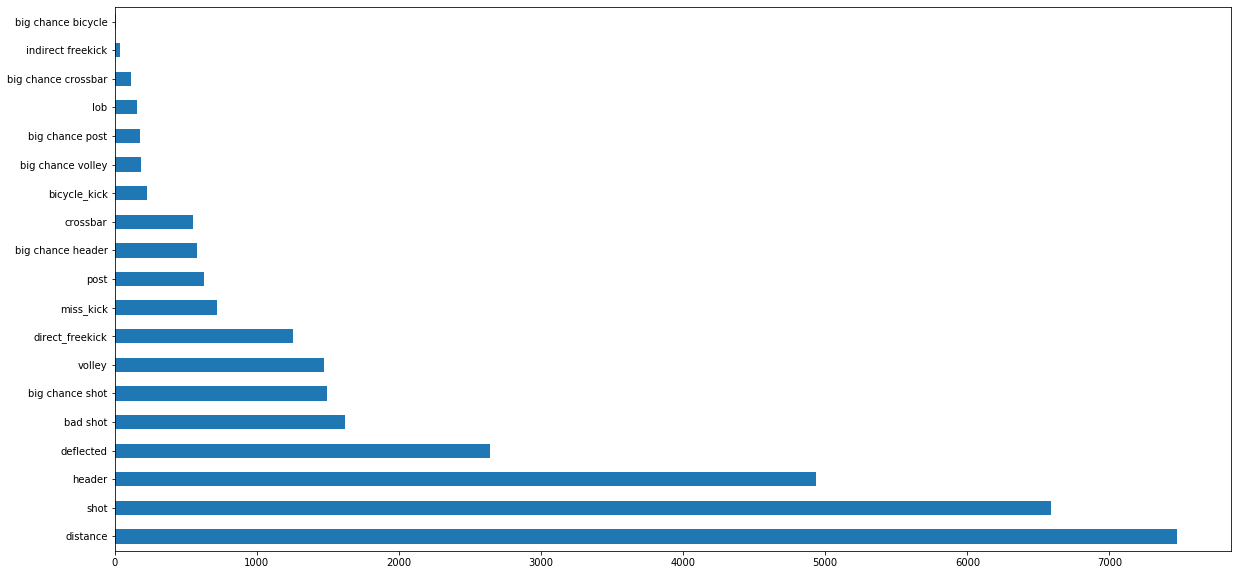

In [27]:
shot_off['subtype'].value_counts().head(30).plot(kind='barh', figsize = (20,10))

Posittion on the pitch

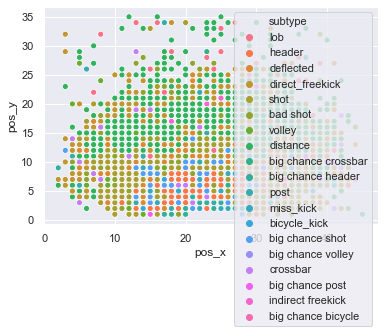

In [28]:
sns.set()


cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="pos_x", y="pos_y",
                     hue="subtype",
                      sizes=(200, 200),
                     data=shot_off)

mean position of the pitch according the subtype

In [29]:
mean_subtype = shot_off.groupby('subtype').mean()
mean_subtype['subtype'] = mean_subtype.index


count_subtype = shot_off.groupby('subtype').count()
count_subtype['subtype'] = count_subtype.index

mean_subtype['count'] = count_subtype.id

In [30]:
mean_subtype.head()

,team,pos_x,pos_y,elapsed,match_id,id,player1,distance,angle,subtype,count
subtype,,,,,,,,,,,
bad shot,9966.729796,23.132716,12.516667,49.061614,8616.375847,4.560128e+06,158645.206663,25.987228,0.448004,bad shot,1623
bicycle_kick,9939.330396,23.268722,7.872247,49.555066,8513.299559,4.577461e+06,136867.008811,27.974512,0.588036,bicycle_kick,227
big chance bicycle,9077.300000,22.700000,6.300000,39.200000,8851.000000,4.415674e+06,74306.000000,28.286563,0.643374,big chance bicycle,10
big chance crossbar,9146.710526,22.447368,7.675439,48.956140,8450.324561,4.563351e+06,161415.815789,27.619117,0.616561,big chance crossbar,114
big chance header,10551.357639,23.159722,5.434028,51.391681,8737.344887,4.648599e+06,146220.178819,29.167231,0.654683,big chance header,577


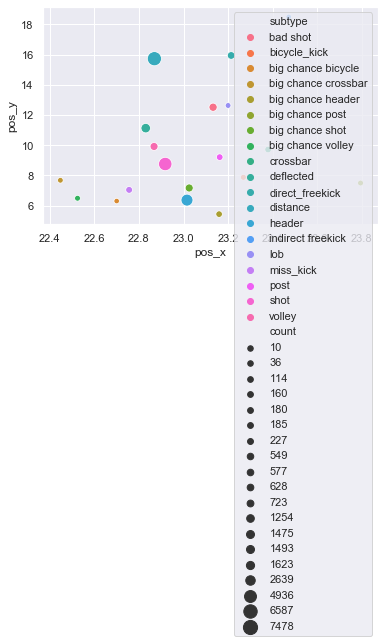

In [31]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="pos_x", y="pos_y",
                     hue="subtype", size = 'count',
                      sizes=(30, 200),
                     data=mean_subtype, legend = 'full')

In [32]:
shot_on.head()

,type,subtype,team,pos_x,pos_y,elapsed,match_id,id,player1,distance,angle
27327,shoton,blocked_shot,9825.0,24.0,14.0,9,4009,3647350,75489.0,25.632011,0.358771
27328,shoton,distance,9825.0,34.0,13.0,27,4009,3647529,192921.0,35.440090,0.286051
27329,shoton,shot,9825.0,20.0,13.0,30,4009,3647540,143793.0,22.360680,0.463648
27330,shoton,blocked_shot,9826.0,13.0,24.0,34,4009,3647565,25537.0,13.038405,0.076772
27331,shoton,blocked_shot,9825.0,17.0,14.0,39,4009,3647592,75489.0,19.235384,0.486899


In [33]:
goals.head()

,elapsed,id,match_id,team,pos_x,pos_y,player1,player2,subtype,comment,distance,angle
6548,35,3647567,4009,9826.0,18.0,3.0,26777.0,35345.0,header,n,26.907248,0.837981
6549,45,3647657,4009,9825.0,21.0,5.0,46539.0,50047.0,header,n,27.658633,0.708626
6550,90,3648213,4009,9825.0,21.0,2.0,75489.0,NaN,tap_in,n,29.698485,0.785398
6551,14,3652629,4010,8191.0,32.0,10.0,37240.0,24372.0,shot,n,34.539832,0.385883
6552,17,3652637,4010,8455.0,26.0,6.0,19243.0,NaN,loose_ball,n,31.064449,0.579074


# Modelisation Xg shot

In [34]:
#dictionnary to create new categories of shots(larger)

shot_category = {}

shot_category['header'] = 'header'
shot_category['loose_ball'] = 'normal_shots'
shot_category['shot'] = 'normal_shots'
shot_category['crossbar'] = 'normal_shots'
shot_category['saved'] = 'normal_shots'
shot_category['post'] = 'normal_shots'
shot_category['direct_freekick'] = 'direct_free_kicks'
shot_category['tap_in'] = 'normal_shots'
shot_category['missed'] = 'normal_shots'
shot_category['big chance header'] = 'header'
shot_category['big chance shot'] = 'normal_shots'
shot_category['indirect freekick'] = 'indirect_free_kicks'
shot_category['deflected'] = 'normal_shots'
shot_category['bad shot'] = 'normal_shots'
shot_category['big chance crossbar'] = 'normal_shots'
shot_category['big chance post'] = 'normal_shots'
shot_category['saved_back_into_play'] = 'normal_shots'
shot_category['miss_kick'] = 'normal_shots'
shot_category['lob'] = 'normal_shots'
shot_category['blocked_shot'] = 'normal_shots'
shot_category['blocked_header'] = 'header'
shot_category['big chance bicycle'] = 'bicycle_kicks'
shot_category['volley'] = 'volley'
shot_category['big chance volley'] = 'volley'
shot_category['distance'] = 'normal_shots'
shot_category['backheel'] = 'normal_shots'
shot_category['big chance blocked'] = 'normal_shots'
shot_category['bicycle_kick'] = 'bicycle_kicks'

In [35]:
#creta a new column outcome. 1 for a goal, 0 for a missing shot
goals['outcome'] = 1

shot_on['outcome'] = 0

shot_off['outcome'] = 0

In [36]:
shot_off.head()

,type,subtype,team,pos_x,pos_y,elapsed,match_id,id,player1,distance,angle,outcome
27791,shotoff,lob,9825.0,20.0,14.0,16,4009,3647440,50047.0,21.931712,0.422854,0
27792,shotoff,header,9825.0,18.0,6.0,30,4009,3647543,50047.0,24.758837,0.756835,0
27793,shotoff,deflected,9825.0,29.0,13.0,37,4009,3647579,37436.0,30.675723,0.332059,0
27794,shotoff,direct_freekick,9825.0,5.0,6.0,78,4009,3648054,50047.0,17.720045,1.284745,0
27795,shotoff,shot,9825.0,17.0,4.0,84,4009,3648118,46469.0,25.495098,0.840897,0


In [37]:
#modify subtypes for larger subtypes
new_subtypes = []
subtypes = list(goals['subtype'])
for subtype in subtypes :
    if type(subtype) == str :
        new_subtypes.append(shot_category[subtype])
    else : 
        new_subtypes.append('normal_shots')
        
goals['new_subtype'] = new_subtypes

new_subtypes = []
subtypes = list(shot_on['subtype'])
for subtype in subtypes :
    if type(subtype) == str :
        new_subtypes.append(shot_category[subtype])
    else : 
        new_subtypes.append('normal_shots')
        
shot_on['new_subtype'] = new_subtypes

new_subtypes = []
subtypes = list(shot_off['subtype'])
for subtype in subtypes :
    if type(subtype) == str :
        new_subtypes.append(shot_category[subtype])
    else : 
        new_subtypes.append('normal_shots')
        
shot_off['new_subtype'] = new_subtypes

goals.head()

,elapsed,id,match_id,team,pos_x,pos_y,player1,player2,subtype,comment,distance,angle,outcome,new_subtype
6548,35,3647567,4009,9826.0,18.0,3.0,26777.0,35345.0,header,n,26.907248,0.837981,1,header
6549,45,3647657,4009,9825.0,21.0,5.0,46539.0,50047.0,header,n,27.658633,0.708626,1,header
6550,90,3648213,4009,9825.0,21.0,2.0,75489.0,NaN,tap_in,n,29.698485,0.785398,1,normal_shots
6551,14,3652629,4010,8191.0,32.0,10.0,37240.0,24372.0,shot,n,34.539832,0.385883,1,normal_shots
6552,17,3652637,4010,8455.0,26.0,6.0,19243.0,NaN,loose_ball,n,31.064449,0.579074,1,normal_shots


**Classification models for Xgoals** 


ONE model is created for each shot subtype

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
#create X and Y vectors to fit models
x_features = ['new_subtype', 'distance', 'angle', 'pos_x', 'pos_y']
y_features = ['outcome']


#feature creation
x_shot_on = shot_on#[x_features]
x_shot_off = shot_off#[x_features]
x_goals = goals#[x_features]
X = pd.concat([x_shot_on, x_shot_off, x_goals])

#target creation
y_shot_on = shot_on[y_features]
y_shot_off = shot_off[y_features]
y_goals = goals[y_features]
Y = pd.concat([y_shot_on, y_shot_off, y_goals])

#shots without angle and distance are removed
index_to_delete = X[X.distance.isna()].index

X = X.drop(index_to_delete)
Y = Y.drop(index_to_delete)


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [40]:
x_shot_on

,type,subtype,team,pos_x,pos_y,elapsed,match_id,id,player1,distance,angle,outcome,new_subtype
27327,shoton,blocked_shot,9825.0,24.0,14.0,9,4009,3647350,75489.0,25.632011,0.358771,0,normal_shots
27328,shoton,distance,9825.0,34.0,13.0,27,4009,3647529,192921.0,35.440090,0.286051,0,normal_shots
27329,shoton,shot,9825.0,20.0,13.0,30,4009,3647540,143793.0,22.360680,0.463648,0,normal_shots
27330,shoton,blocked_shot,9826.0,13.0,24.0,34,4009,3647565,25537.0,13.038405,0.076772,0,normal_shots
27331,shoton,blocked_shot,9825.0,17.0,14.0,39,4009,3647592,75489.0,19.235384,0.486899,0,normal_shots
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73070,shoton,shot,8600.0,17.0,5.0,73,13273,4953726,27734.0,24.758837,0.813962,0,normal_shots
73071,shoton,shot,9891.0,32.0,9.0,83,13273,4953922,181921.0,34.928498,0.412410,0,normal_shots
73072,shoton,big chance shot,8600.0,20.0,8.0,90,13273,4954115,38920.0,25.000000,0.643501,0,normal_shots
73073,shoton,direct_freekick,8600.0,18.0,12.0,90,13273,4954137,41694.0,21.095023,0.548549,0,direct_free_kicks


In [41]:
#new_subtypes used grouping former subtypes
set(X.new_subtype)

{'bicycle_kicks',
 'direct_free_kicks',
 'header',
 'indirect_free_kicks',
 'normal_shots',
 'volley'}

In [42]:
#targets and features in the same dataframe
xy_concat = pd.concat([X,Y], axis = 1)

#One dataframe for each subtype ==> create one model for each subtype
#backheel = xy_concat[xy_concat.new_subtype == 'backheel']
bicycle_kicks = xy_concat[xy_concat.new_subtype == 'bicycle_kicks']
direct_free_kicks = xy_concat[xy_concat.new_subtype == 'direct_free_kicks']
header = xy_concat[xy_concat.new_subtype == 'header']
indirect_free_kicks = xy_concat[xy_concat.new_subtype == 'indirect_free_kicks']
normal_shots = xy_concat[xy_concat.new_subtype == 'normal_shots']
volley = xy_concat[xy_concat.new_subtype == 'volley']

In [43]:
#list of dataframes for ecah subtype
df_shot_types = [bicycle_kicks, direct_free_kicks, header, indirect_free_kicks, normal_shots, volley]

In [44]:
volley

,angle,comment,distance,elapsed,id,match_id,new_subtype,outcome,player1,player2,pos_x,pos_y,subtype,team,type,outcome
27358,0.512389,NaN,36.715120,86,3649756,4012,volley,0,279490.0,NaN,32.0,5.0,volley,8466.0,shoton,0
27464,0.499347,NaN,25.059928,62,3896080,4021,volley,0,109638.0,NaN,22.0,11.0,volley,10172.0,shoton,0
27473,0.661043,NaN,22.803509,45,3909717,4022,volley,0,188540.0,NaN,18.0,9.0,volley,8472.0,shoton,0
27479,0.600050,NaN,23.021729,62,3909897,4022,volley,0,188540.0,NaN,19.0,10.0,volley,8472.0,shoton,0
27551,0.699893,NaN,24.839485,20,3922919,4029,volley,0,214426.0,NaN,19.0,7.0,volley,8191.0,shoton,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29181,0.439843,n,37.576588,48,4842613,13243,volley,1,362113.0,33640.0,34.0,7.0,volley,9804.0,NaN,1
29191,0.817645,n,21.931712,90,4882311,13247,volley,1,37441.0,21613.0,15.0,7.0,volley,8535.0,NaN,1
29192,0.620249,n,25.806976,6,4878546,13248,volley,1,40659.0,500502.0,21.0,8.0,volley,9857.0,NaN,1
29197,0.514451,n,26.419690,90,4880735,13249,volley,1,106292.0,NaN,23.0,10.0,volley,8543.0,NaN,1


In [45]:
#Shufling and conversion into np array
#backheel = np.array(backheel.sample(frac  =1))
bicycle_kicks = np.array(bicycle_kicks.sample(frac  =1))
direct_free_kicks = np.array(direct_free_kicks.sample(frac  =1))
header = np.array(header.sample(frac  =1))
indirect_free_kicks = np.array(indirect_free_kicks.sample(frac  =1))
normal_shots = np.array(normal_shots.sample(frac  =1))
volley = np.array(volley.sample(frac  =1))

In [46]:
bicycle_kicks

array([[0.5984188934785372, nan, 26.627053911388696, ..., 9789.0,
        'shotoff', 0],
       [0.6107259643892086, nan, 24.413111231467404, ..., 8177.0,
        'shotoff', 0],
       [0.6107259643892086, nan, 24.413111231467404, ..., 8592.0,
        'shotoff', 0],
       ...,
       [0.5645693936681, nan, 35.510561809129406, ..., 8586.0, 'shoton',
        0],
       [0.5144513130590277, nan, 26.419689627245813, ..., 10261.0,
        'shotoff', 0],
       [0.5667292175235064, nan, 26.076809620810597, ..., 8636.0,
        'shotoff', 0]], dtype=object)

In [47]:
#splitting into feature and target for each subtype
#x_backheel = backheel[:, 1:5]
#y_backheel = backheel[:, 5].astype(int)

x_bicycle_kicks = bicycle_kicks[:, 1:bicycle_kicks.shape[1]-1]
y_bicycle_kicks = bicycle_kicks[:, bicycle_kicks.shape[1]-1].astype(int)

x_direct_free_kicks = direct_free_kicks[:, 1:direct_free_kicks.shape[1]-1]
y_direct_free_kicks = direct_free_kicks[:, direct_free_kicks.shape[1]-1].astype(int)

x_header = header[:, 1:header.shape[1]-1]
y_header = header[:, header.shape[1]-1].astype(int)

x_indirect_free_kicks = indirect_free_kicks[:, 1:indirect_free_kicks.shape[1]-1]
y_indirect_free_kicks = indirect_free_kicks[:, indirect_free_kicks.shape[1]-1].astype(int)

x_normal_shots = normal_shots[:, 1:normal_shots.shape[1]-1]
y_normal_shots = normal_shots[:, normal_shots.shape[1]-1].astype(int)

x_volley = volley[:, 1:volley.shape[1]-1]
y_volley = volley[:, volley.shape[1]-1].astype(int)

Shots distribution(Goal or missing shot=

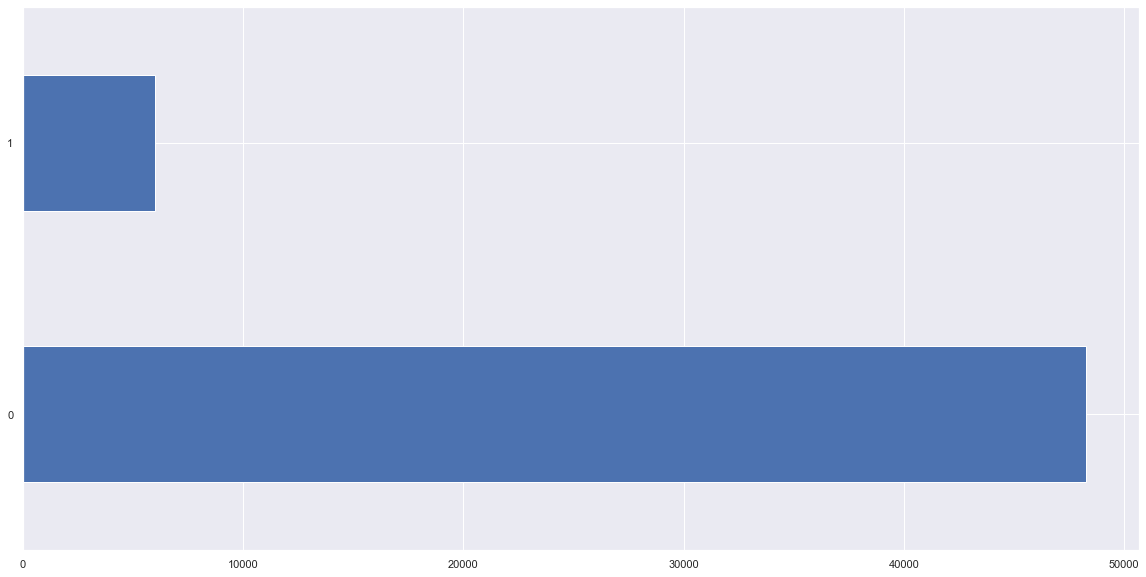

In [48]:
pd.Series(y_normal_shots).value_counts().head(5).plot(kind='barh', figsize = (20,10))

In [49]:
#create dataframe for each type of shot
features = ['angle', 'comment', 'distance', 'elapsed', 'id', 'match_id', 'new_subtype', 'outcome', 'player1',
            'player2', 'pos_x', 'pos_y', 'subtype', 'team', 'type', 'target']

data = normal_shots #to modify according the shot type of your choice
df_normal_shots = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)

#data = backheel #to modify according the shot type of your choice
df_backheel = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)

data = bicycle_kicks #to modify according the shot type of your choice
df_bicycle_kicks = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)

data = direct_free_kicks #to modify according the shot type of your choice
df_direct_free_kicks = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)

data = header #to modify according the shot type of your choice
df_header = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)

data = indirect_free_kicks #to modify according the shot type of your choice
df_indirect_free_kicks = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)

data = volley #to modify according the shot type of your choice
df_volley = pd.DataFrame(data = data, index = range(data.shape[0]),columns = features)


In [50]:
df_volley

,angle,comment,distance,elapsed,id,match_id,new_subtype,outcome,player1,player2,pos_x,pos_y,subtype,team,type,target
0,0.603749,NaN,35.2278,5,4366726,7314,volley,0,91560,NaN,29,3,volley,8550,shotoff,0
1,0.530216,NaN,33.6155,45,5608935,7747,volley,0,46653,NaN,29,6,volley,9837,shotoff,0
2,0.785398,NaN,21.2132,50,3961622,7103,volley,0,38098,NaN,15,8,volley,8592,shoton,0
3,0.244979,NaN,24.7386,53,4282189,4245,volley,0,23293,NaN,24,17,big chance volley,8466,shotoff,0
4,0.295441,NaN,24.0416,90,5330306,10093,volley,0,28435,NaN,23,16,volley,8722,shotoff,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2735,0.545655,NaN,32.7567,42,5393061,7665,volley,0,134221,NaN,28,6,volley,10249,shoton,0
2736,0.88848,NaN,20.6155,53,4982897,9972,volley,0,27352,NaN,13,7,volley,8262,shotoff,0
2737,0.588003,NaN,25.2389,53,5537343,13178,volley,0,11685,NaN,21,9,volley,8543,shotoff,0
2738,0.91795,NaN,21.4009,31,3880659,7069,volley,0,469852,NaN,13,6,volley,9748,shoton,0


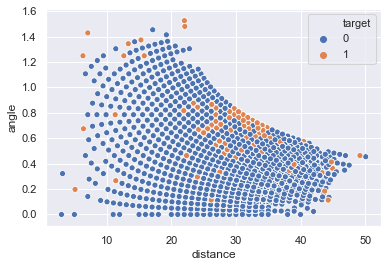

In [51]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
ax = sns.scatterplot(x="distance", y="angle",
                     hue="target",
                      sizes=(30, 200),
                     data=df_normal_shots, legend = 'full')

Accuracy of each model is going to be very high because classes (goal or not) are unbalanced

Bayesian Classifier is the best one according to the scientific paper

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold, KFold

Select data to train models. It is a case of unbalanced classes, so a train dataset with balanced classes

In [53]:
def create_training_dataset(data) :
    
    '''
    data :  data with unbalanced classes
    '''
    '''
    if (data.target == 1).sum() > 0 and (data.target == 0).sum() > 0 :
        class_1 = (data.target == 1).sum() #Qty of goals
    
        data_no_goal = data[data.target == 0] #only shots involving no goal
    
   
        data_no_goal = data_no_goal.sample(n=class_1, replace=True, random_state = 1) #no goal shots dataframe with the same qty than
                                                                        #class_1 for balanced classes
    
        data_for_training = pd.concat([data_no_goal, data[data.target == 1]])        
    
        
    '''
    
    data_for_training = data
    return data_for_training.sample(frac = 1)

In [54]:
training_normal_shots = create_training_dataset(df_normal_shots)

#training_backheel = create_training_dataset(df_backheel)

training_bicycle_kicks = create_training_dataset(df_bicycle_kicks)

training_direct_free_kicks = create_training_dataset(df_direct_free_kicks)

training_header = create_training_dataset(df_header)

training_indirect_free_kicks = create_training_dataset(df_indirect_free_kicks)

training_volley = create_training_dataset(df_volley)

Kfold validation to train the model correctly for normal_shots

In [55]:
kf = KFold(n_splits = 10)

In [56]:
clf_normal_shots = RandomForestClassifier()

#cross val à 10 folds
scores = cross_val_score(estimator = clf_normal_shots, X = training_normal_shots[['distance','angle']],y = training_normal_shots['target'].astype(int),
                         scoring = 'accuracy', cv = kf)


#learning curve to control overfitting
train_sizes = [5, 30, 100, 2000, 5000, 7000, 10000, 14000]
train_sizes, train_scores, test_scores = learning_curve(estimator = clf_normal_shots, X = training_normal_shots[['distance','angle']],
                y = training_normal_shots['target'].astype(int),
               scoring = 'accuracy', cv = kf, train_sizes = train_sizes,
               random_state = 1)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

In [57]:
mean_training_score = train_scores.mean(axis = 1)
mean_test_score = test_scores.mean(axis = 1)

In [58]:
print('control standard error to know if all the dataset behave in the same way\n')
print('Test_score on each fold\n')
for i in range(scores.shape[0]) :
    print('Test_score fold n°{} : {}'.format(i+1, scores[i]))

On contrôle la variance du train score pour savoir si tout le jue de donnée se comporte de la même manière

Test_score sur chaque fold

Test_score fold n°1 : 0.904165130851456
Test_score fold n°2 : 0.9078510873571692
Test_score fold n°3 : 0.9087725764835974
Test_score fold n°4 : 0.9115370438628824
Test_score fold n°5 : 0.904718024327313
Test_score fold n°6 : 0.9071138960560265
Test_score fold n°7 : 0.9078510873571692
Test_score fold n°8 : 0.9107834101382488
Test_score fold n°9 : 0.9065437788018433
Test_score fold n°10 : 0.911520737327189


In [59]:
print('\n', '-' * 20) # separator
print('Mean training score\n\n', pd.Series(mean_training_score, index = train_sizes) )

print('\n', '-' * 20) #separator
print('Mean test score\n\n', pd.Series(mean_test_score, index = train_sizes))


 --------------------
Mean training score

 5        0.980000
30       0.980000
100      0.982000
2000     0.918900
5000     0.909940
7000     0.908286
10000    0.909570
14000    0.909286
dtype: float64

 --------------------
Mean test score

 5        0.829863
30       0.892751
100      0.893562
2000     0.891830
5000     0.901985
7000     0.904510
10000    0.905450
14000    0.906390
dtype: float64


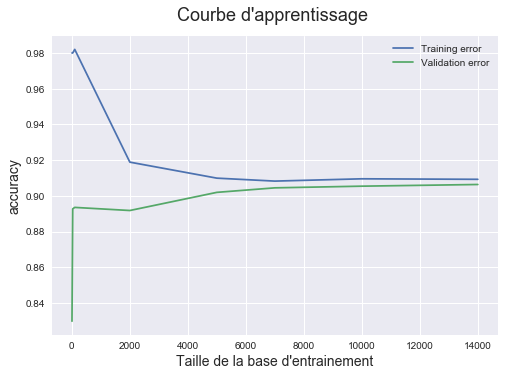

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.plot(train_sizes, mean_training_score, label = 'Training error')
plt.plot(train_sizes, mean_test_score, label = 'Validation error')

plt.ylabel('accuracy', fontsize=14)
plt.xlabel('Size of the training dataset', fontsize=14)
plt.title("Learning Curve ", fontsize=18, y=1.03)
plt.legend()

Create one model for each shot type

In [61]:
#one model for each type of shot
model_normal_shots = LogisticRegression()
model_direct_free_kicks = LogisticRegression()
model_bicycle_kicks = LogisticRegression()
model_header = LogisticRegression()
model_indirect_free_kicks = LogisticRegression()
model_volley = LogisticRegression()
models = [model_normal_shots, model_direct_free_kicks, model_bicycle_kicks, model_header, model_indirect_free_kicks,
         model_volley]

dic_dataframe = {}
dic_dataframe['normal_shots'] = training_normal_shots
dic_dataframe['direct_free_kicks'] = training_direct_free_kicks
dic_dataframe['bicycle_kicks'] = training_bicycle_kicks
dic_dataframe['header'] = training_header
dic_dataframe['indirect_free_kicks'] = training_indirect_free_kicks
dic_dataframe['volley'] = training_volley

Pour chaque type de tir, il faut prédire la probabailité qu'il soit converti en but (Xg)

In [62]:
model = GaussianNB()
model.fit(training_normal_shots[['distance', 'angle']], training_normal_shots['target'].astype(int))
training_normal_shots['Xg'] = model.predict_proba(training_normal_shots[['distance', 'angle']])[:, 1]

model =  GaussianNB()
model.fit(training_direct_free_kicks[['distance', 'angle']], training_direct_free_kicks['target'].astype(int))
training_direct_free_kicks['Xg'] = model.predict_proba(training_direct_free_kicks[['distance', 'angle']])[:, 1]

model =  GaussianNB()
model.fit(training_bicycle_kicks[['distance', 'angle']], training_bicycle_kicks['target'].astype(int))
training_bicycle_kicks['Xg'] = model.predict_proba(training_bicycle_kicks[['distance', 'angle']])[:, 1]

model =  GaussianNB()
model.fit(training_header[['distance', 'angle']], training_header['target'].astype(int))
training_header['Xg'] = model.predict_proba(training_header[['distance', 'angle']])[:, 1]

model =  GaussianNB()
model.fit(training_indirect_free_kicks[['distance', 'angle']], training_indirect_free_kicks['target'].astype(int))
training_indirect_free_kicks['Xg'] = model.predict_proba(training_indirect_free_kicks[['distance', 'angle']])[:, 1]

model =  GaussianNB()
model.fit(training_volley[['distance', 'angle']], training_volley['target'].astype(int))
training_volley['Xg'] = model.predict_proba(training_volley[['distance', 'angle']])[:, 1]

In [63]:
training_normal_shots

,angle,comment,distance,elapsed,id,match_id,new_subtype,outcome,player1,player2,pos_x,pos_y,subtype,team,type,target,Xg
28276,0.258771,NaN,35.171,50,5360916,10108,normal_shots,0,147735,NaN,34,14,distance,8406,shotoff,0,0.022930
31585,0.255182,NaN,23.7697,79,5531612,10169,normal_shots,0,298915,NaN,23,17,blocked_shot,8721,shoton,0,0.021970
28813,0.426627,NaN,24.1661,54,4319875,9819,normal_shots,0,30937,NaN,22,13,distance,10189,shotoff,0,0.091451
53840,0.577902,npm,27.4591,90,3888801,12884,normal_shots,1,25759,NaN,23,8,saved_back_into_play,9875,NaN,1,0.219006
18646,0.785398,NaN,14.1421,31,5614655,13213,normal_shots,0,244811,NaN,10,13,blocked_shot,9804,shoton,0,0.015532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27778,0.579074,NaN,31.0644,88,4954089,4404,normal_shots,0,165823,NaN,26,6,big chance shot,10260,shoton,0,0.223314
21418,0.394791,NaN,26,30,5188357,13014,normal_shots,0,36121,NaN,24,13,distance,8533,shoton,0,0.090828
47458,0.558599,NaN,28.3019,47,4951918,7458,normal_shots,0,446266,NaN,24,8,blocked_shot,9829,shoton,0,0.214556
14484,0.263964,NaN,38.3275,14,4078529,12622,normal_shots,0,155738,NaN,37,13,shot,8686,shotoff,0,0.013498


Adjust Xg depending on somme parameters :
    1. Weight on shot xG if the team has a player advantage: 0.90
    2. Weight on shot xG if the team has a player disadvantage: 1.25
    3. Weight k on shot xG at end of game if winning by 1 goal: 0.52
    4. Weight k on shot xG at end of game if winning by 2 goals or more: 0.90

Create new_Xg depending on score at 70'

In [64]:
#on créé une nouvelle colonne coef_avantage
def create_column(df, name_col) :
    df[name_col] = 0 #initialisation
    
    return df

In [65]:
def score(df_goals, minute, team_id) :
    
    """
    df : goals for one match
    minute : minute from  wich calcul of the score is done
    team_id : id of the team for which the calcul is done
    
    
    return Calcule l'avantage d'une équipe à un temps donné du match
    """
    
    goals_for = df_goals[df_goals.team == team_id][df_goals.elapsed <= minute].shape[0]
    goals_against = df_goals[df_goals.elapsed <= minute].shape[0] - goals_for
    
    return goals_for - goals_against

In [66]:
def xg_coef(data, df_goals, coef_end_game_1 = 0.52, coef_end_game_2 = 0.90, time_start_coef = 70) :
    
    """
    data : ligne d'un dataframe (une seule donnée)
    
    
    return : coef multiplicateur
    """
    
    if data.elapsed <= 70 :
        coef = 1
    else :
        id_match = data.match_id
        df_goals = df_goals[df_goals.match_id == id_match]
        minute = data.elapsed
        team_id = data.team
        
        
        diff = score(df_goals, minute, team_id)
        
        
        if diff == 1: 
            step = (1 - coef_end_game_1) / (90 - time_start_coef)
            coef = 1 -  (minute - time_start_coef) *step
            
        elif diff >= 2 :
            step = (1 - coef_end_game_2) / (90 - time_start_coef)
            coef = 1 -  (minute - time_start_coef) *step
            
        else :
            coef = 1
                        
    
    return coef      

In [67]:
for df_shots in [training_normal_shots, training_volley, training_indirect_free_kicks, training_direct_free_kicks,
                training_header, training_bicycle_kicks] :
    
    df_shots = create_column(df_shots, 'coef_1_2')
    for i in df_shots.index :
        data = df_shots.loc[i, :]
        coef_xg = xg_coef(data, goals, coef_end_game_1 = 0.52, coef_end_game_2 = 0.90, time_start_coef = 70 )
        df_shots.loc[i, 'coef_1_2'] = coef_xg

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [68]:
#create new Xg
for df_shots in [training_normal_shots, training_volley, training_indirect_free_kicks, training_direct_free_kicks,
                training_header, training_bicycle_kicks] :
    
    df_shots = create_column(df_shots, 'new_xg_1_2')
    df_shots['new_xg_1_2'] = df_shots['Xg'] * df_shots['coef_1_2']

Create new Xg depending on player (dis)advantage

In [69]:
def advantage(cards, minute, team_id) :
    
    """
    df : goals for one match
    minute : minute from  wich calcul of the score is done
    team_id : id of the team for which the calcul is done
    
    
    return Calcule l'avantage d'une équipe à un temps donné du match
    """
    
    cards_for_red = cards[cards.team == team_id][cards.elapsed <= minute][cards.card_type == 'r'].shape[0]
    cards_for_y2 = cards[cards.team == team_id][cards.elapsed <= minute][cards.card_type == 'y2'].shape[0]  
    cards_for = cards_for_red + cards_for_y2                                                                    
                                                                         
                                                                         
    cards_against_red = cards[cards.elapsed <= minute][cards.card_type == 'r'].shape[0] - cards_for_red
    cards_against_y2 = cards[cards.elapsed <= minute][cards.card_type == 'r'].shape[0] - cards_for_y2
    cards_against = cards_against_red + cards_against_y2
    
    return cards_against - cards_for

In [70]:
def xg_player_advantage(data, cards, coef_advantage = 0.90, coef_disadvantage = 1.25) :
    
    id_match = data.match_id
    cards = cards[cards.match_id == id_match]
    minute = data.elapsed
    team_id = data.team
    
    if advantage(cards, minute, team_id) > 0 :
        coef = coef_advantage
    
    elif advantage(cards, minute, team_id) < 0 :
        coef = coef_disadvantage
        
    else :
        coef = 1
        
    return coef
    

In [71]:
for df_shots in [training_normal_shots, training_volley, training_indirect_free_kicks, training_direct_free_kicks,
                training_header, training_bicycle_kicks] :
    
    print(df_shots)
    
    df_shots = create_column(df_shots, 'coef_dis_advantage')
    
    j=0
    for i in df_shots.index :
        
        if j%1000 == 0:
            print(j)
        
        data = df_shots.loc[i, :]
        coef_advantage = xg_player_advantage(data, cards, coef_advantage = 0.90, coef_disadvantage = 1.25)
        df_shots.loc[i, 'coef_dis_advantage'] = coef_advantage
        j+=1

          angle comment distance elapsed       id match_id   new_subtype  \
28276  0.258771     NaN   35.171      50  5360916    10108  normal_shots   
31585  0.255182     NaN  23.7697      79  5531612    10169  normal_shots   
28813  0.426627     NaN  24.1661      54  4319875     9819  normal_shots   
53840  0.577902     npm  27.4591      90  3888801    12884  normal_shots   
18646  0.785398     NaN  14.1421      31  5614655    13213  normal_shots   
...         ...     ...      ...     ...      ...      ...           ...   
27778  0.579074     NaN  31.0644      88  4954089     4404  normal_shots   
21418  0.394791     NaN       26      30  5188357    13014  normal_shots   
47458  0.558599     NaN  28.3019      47  4951918     7458  normal_shots   
14484  0.263964     NaN  38.3275      14  4078529    12622  normal_shots   
14693  0.343024     NaN  29.7321      75  5119311     4471  normal_shots   

      outcome player1 player2 pos_x pos_y               subtype   team  \
28276       0

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
         angle comment distance elapsed       id match_id new_subtype outcome  \
389   0.439843     NaN  37.5766      26  5211161    13029      volley       0   
1805  0.222082     NaN  31.7805      10  4209918     9785      volley       0   
825    0.30092     NaN  30.3645      81  4393338     4288      volley       0   
1572  0.554307     NaN  24.6982      14  4151984    12657      volley       0   
37    0.380506     NaN  21.5407      59  4222280    12691      volley       0   
...        ...     ...      ...     ...      ...      ...         ...     ...   
2075  0.408149       n  40.3113       1  4947631     7452      volley       1   
482   0.262995       n  26.9258      

In [72]:
df_shots

,angle,comment,distance,elapsed,id,match_id,new_subtype,outcome,player1,player2,pos_x,pos_y,subtype,team,type,target,Xg,coef_1_2,new_xg_1_2,coef_dis_advantage
3,0.496423,n,27.2947,60,4814933,10221,bicycle_kicks,1,93447,177714,24,10,bicycle_kick,9823,NaN,1,0.101478,1.000,0.101478,1.0
288,0.397079,NaN,33.6155,41,5332069,10088,bicycle_kicks,0,27316,NaN,31,10,bicycle_kick,9790,shoton,0,0.018603,1.000,0.018603,1.0
229,0.628796,NaN,27.2029,5,4403167,9854,bicycle_kicks,0,114044,NaN,22,7,bicycle_kick,9788,shoton,0,0.206440,1.000,0.206440,1.0
178,0.643501,NaN,30,81,3877416,9944,bicycle_kicks,0,30764,NaN,24,5,bicycle_kick,8721,shoton,0,0.195818,0.945,0.185048,1.0
289,0.726642,NaN,24.0832,20,4116360,7200,bicycle_kicks,0,109280,NaN,18,7,bicycle_kick,7819,shoton,0,0.193554,1.000,0.193554,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.507099,NaN,30.8869,84,4054964,12596,bicycle_kicks,0,42437,NaN,27,8,bicycle_kick,8533,shotoff,0,0.092706,1.000,0.092706,1.0
219,0.476467,NaN,34.8855,90,5507952,13156,bicycle_kicks,0,74382,NaN,31,7,bicycle_kick,9891,shotoff,0,0.035972,0.520,0.018706,1.0
317,0.519146,NaN,32.249,12,4166407,12668,bicycle_kicks,0,46241,NaN,28,7,bicycle_kick,10233,shoton,0,0.086085,1.000,0.086085,1.0
280,0.726642,NaN,24.0832,33,4232976,7254,bicycle_kicks,0,52133,NaN,18,7,bicycle_kick,9847,shotoff,0,0.193554,1.000,0.193554,1.0


In [73]:
#create new Xg
for df_shots in [training_normal_shots, training_volley, training_indirect_free_kicks, training_direct_free_kicks,
                training_header, training_bicycle_kicks] :
    
    df_shots = create_column(df_shots, 'new_xg_advantage')
    df_shots['new_xg_advantage'] = df_shots['new_xg_1_2'] * df_shots['coef_dis_advantage']

In [74]:
#expected goals for all shots
training_all_shots = pd.concat([training_normal_shots, training_volley, training_indirect_free_kicks, training_direct_free_kicks,
                training_header, training_bicycle_kicks])

In [75]:
training_all_shots

,angle,comment,distance,elapsed,id,match_id,new_subtype,outcome,player1,player2,...,pos_y,subtype,team,type,target,Xg,coef_1_2,new_xg_1_2,coef_dis_advantage,new_xg_advantage
28276,0.258771,NaN,35.171,50,5360916,10108,normal_shots,0,147735,NaN,...,14,distance,8406,shotoff,0,0.022930,1.00,0.022930,1.0,0.022930
31585,0.255182,NaN,23.7697,79,5531612,10169,normal_shots,0,298915,NaN,...,17,blocked_shot,8721,shoton,0,0.021970,1.00,0.021970,1.0,0.021970
28813,0.426627,NaN,24.1661,54,4319875,9819,normal_shots,0,30937,NaN,...,13,distance,10189,shotoff,0,0.091451,1.00,0.091451,1.0,0.091451
53840,0.577902,npm,27.4591,90,3888801,12884,normal_shots,1,25759,NaN,...,8,saved_back_into_play,9875,NaN,1,0.219006,0.52,0.113883,1.0,0.113883
18646,0.785398,NaN,14.1421,31,5614655,13213,normal_shots,0,244811,NaN,...,13,blocked_shot,9804,shoton,0,0.015532,1.00,0.015532,1.0,0.015532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.507099,NaN,30.8869,84,4054964,12596,bicycle_kicks,0,42437,NaN,...,8,bicycle_kick,8533,shotoff,0,0.092706,1.00,0.092706,1.0,0.092706
219,0.476467,NaN,34.8855,90,5507952,13156,bicycle_kicks,0,74382,NaN,...,7,bicycle_kick,9891,shotoff,0,0.035972,0.52,0.018706,1.0,0.018706
317,0.519146,NaN,32.249,12,4166407,12668,bicycle_kicks,0,46241,NaN,...,7,bicycle_kick,10233,shoton,0,0.086085,1.00,0.086085,1.0,0.086085
280,0.726642,NaN,24.0832,33,4232976,7254,bicycle_kicks,0,52133,NaN,...,7,bicycle_kick,9847,shotoff,0,0.193554,1.00,0.193554,1.0,0.193554


# Modelisation Xg Match (for team)

1. Xg match is the sum of Xg shot

In [76]:
#create dataframe for Xg match
df_xg_match = pd.DataFrame(index = new_match_data.index, columns = ['match_id', 'season', 'league', 'team_1', 'team_2', 'Xg_team_1', 'Xg_team_2'])

In [77]:
df_xg_match[['match_id', 'season', 'league', 'day', 'team_1', 'team_2']] = new_match_data[['id','season', 'league_id', 'stage' ,'home_team_api_id', 'away_team_api_id']]

In [78]:
#calcul Xg match
#ATTENTION !!! : certains matchs n'ont pas de stats de tirs donc pas de Xg...
j=0 #for cpt
for i in df_xg_match.index :
    id_match = df_xg_match.loc[i, 'match_id']
    id_team_1 = df_xg_match.loc[i, 'team_1']
    id_team_2 = df_xg_match.loc[i, 'team_2']
    
    #print(id_match)
        
    training_all_shots_match = training_all_shots[training_all_shots.match_id == id_match]
    match_xg_team_1 = training_all_shots_match[training_all_shots_match.team == id_team_1].new_xg_advantage.sum()
    match_xg_team_2 = training_all_shots_match[training_all_shots_match.team == id_team_2].new_xg_advantage.sum()
    
    
    #print(match_xg_team_1)
    
    df_xg_match.loc[i, 'Xg_team_1'] = match_xg_team_1
    df_xg_match.loc[i, 'Xg_team_2'] = match_xg_team_2
    
    if j%1000 == 0 :
        print(j/len(list(df_xg_match.index))*100)
        
    j+=1

0.0
34.59010722933241
69.18021445866482


2. Xg match with other statistics. Lack of data to complete this part. Our model would have been better with it

summary df_xg_match

In [81]:
df_xg_match.head()

,match_id,season,league,team_1,team_2,Xg_team_1,Xg_team_2,day
4008,4009,2014/2015,1729,9825,9826,1.1575,0.208508,1
4009,4010,2014/2015,1729,8191,8455,0.506293,1.23842,1
4010,4011,2014/2015,1729,8197,8668,1.18213,1.58629,1
4011,4012,2014/2015,1729,8650,8466,0.841446,1.17535,1
4012,4013,2014/2015,1729,10260,10003,1.35247,0.481599,1


# ELO calculation

In [82]:
def elo_t2(elo_t1, actual_Xg, expected_Xg, learning_rate = 0.12) :
    
    """
    UPdate an Elo score after each math
    
    elo_t1 : score elo before the matchh, ie, of the previous stage
    actual_Xg : expected goals post match
    
    expected_Xg : 
    The expected number of expected goals value is a weighted average of: 
    ⇤ a team’s general offensive rating
    ⇤ this team’s home/away-speciﬁc offensive rating 
    ⇤ the opposing team’s general defensive rating 
    ⇤ the opposing team’s home/away-speciﬁc defensive rating
    
    Return : Score Elo actualisé
    
    """
    
    updated_elo = elo_t1 + learning_rate*(actual_Xg - expected_Xg)
    
    return updated_elo

In [83]:
def expected_Xg(gen_off_rating, home_off_rating, away_off_rating, gen_def_opp_rating,
                home_def_opp_rating, away_def_opp_rating, home , away, weight = 0.20 ) :
    
    
    """
    Return Expected goals value
    
    homme / away : booleans if match is home or away for the actual team
    
    """
    
    if home == True and away == False :
        expected_Xg = (1- weight)*(gen_off_rating+gen_def_opp_rating) + weight*(home_off_rating+away_def_opp_rating)/2
    
    if home == False and away == True :
        expected_Xg = (1- weight)*(gen_off_rating+gen_def_opp_rating) + weight*(away_off_rating+home_def_opp_rating)/2
    
    
    return expected_Xg

In [84]:
def set_elo_rating(match_data) :
    
    teams = list(set(match_data[match_data.season == '2013/2014'].home_team_api_id))
    
    elo_13_14 = pd.DataFrame(index = range(len(teams)), columns = ['teams', 'goals_for', 'goals_against',
                                                                  'goals_for_home', 'goals_for_away',
                                                                  'goals_against_home', 'goals_against_away'])
    elo_13_14['teams'] = teams
    
    for i in elo_13_14.index :
        print(round(i/len(teams)*100,2))
        team_id = elo_13_14.loc[i, 'teams']
        goals_for_home = match_data[match_data.season == '2013/2014'][match_data.home_team_api_id == team_id].home_team_goal.sum() / match_data[match_data.season == '2013/2014'][match_data.home_team_api_id == team_id].home_team_goal.shape[0]
            
        goals_against_home = match_data[match_data.season == '2013/2014'][match_data.home_team_api_id == team_id].away_team_goal.sum()/ match_data[match_data.season == '2013/2014'][match_data.home_team_api_id == team_id].away_team_goal.shape[0]
        
        goals_for_away = match_data[match_data.season == '2013/2014'][match_data.away_team_api_id == team_id].away_team_goal.sum() / match_data[match_data.season == '2013/2014'][match_data.away_team_api_id == team_id].away_team_goal.shape[0]
            
        goals_against_away = match_data[match_data.season == '2013/2014'][match_data.away_team_api_id == team_id].home_team_goal.sum() / match_data[match_data.season == '2013/2014'][match_data.away_team_api_id == team_id].home_team_goal.shape[0]
    
        goals_for = (goals_for_home + goals_for_away)/2
        goals_against = (goals_against_home + goals_against_away)/2
        
        elo_13_14.loc[i, ['goals_for', 'goals_against', 'goals_for_home', 'goals_for_away',
                        'goals_against_home', 'goals_against_away']] = [goals_for, goals_against, goals_for_home,
                                                                        goals_for_away, goals_against_home,
                                                                        goals_against_away]
        
    return elo_13_14

In [85]:
set_elo = set_elo_rating(match_data)

0.0
0.57
1.15
1.72


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2.3
2.87
3.45
4.02
4.6
5.17
5.75
6.32
6.9
7.47
8.05
8.62
9.2
9.77
10.34
10.92
11.49
12.07
12.64
13.22
13.79
14.37
14.94
15.52
16.09
16.67
17.24
17.82
18.39
18.97
19.54
20.11
20.69
21.26
21.84
22.41
22.99
23.56
24.14
24.71
25.29
25.86
26.44
27.01
27.59
28.16
28.74
29.31
29.89
30.46
31.03
31.61
32.18
32.76
33.33
33.91
34.48
35.06
35.63
36.21
36.78
37.36
37.93
38.51
39.08
39.66
40.23
40.8
41.38
41.95
42.53
43.1
43.68
44.25
44.83
45.4
45.98
46.55
47.13
47.7
48.28
48.85
49.43
50.0
50.57
51.15
51.72
52.3
52.87
53.45
54.02
54.6
55.17
55.75
56.32
56.9
57.47
58.05
58.62
59.2
59.77
60.34
60.92
61.49
62.07
62.64
63.22
63.79
64.37
64.94
65.52
66.09
66.67
67.24
67.82
68.39
68.97
69.54
70.11
70.69
71.26
71.84
72.41
72.99
73.56
74.14
74.71
75.29
75.86
76.44
77.01
77.59
78.16
78.74
79.31
79.89
80.46
81.03
81.61
82.18
82.76
83.33
83.91
84.48
85.06
85.63
86.21
86.78
87.36
87.93
88.51
89.08
89.66
90.23
90.8
91.38
91.95
92.53
93.1
93.68
94.25
94.83
95.4
95.98
96.55
97.13
97.7
98.28
98.85
99.43


In [86]:
set_elo

,teams,goals_for,goals_against,goals_for_home,goals_for_away,goals_against_home,goals_against_away
0,10243,1.41667,1.44444,1.55556,1.27778,1.33333,1.55556
1,10249,1.18421,1.39474,1.15789,1.21053,1,1.78947
2,10251,0.805556,1.33611,1,0.611111,1.45,1.22222
3,10252,1.02632,1.60526,1.15789,0.894737,1.52632,1.68421
4,8721,1.85294,1.47059,2.17647,1.52941,1.29412,1.64706
...,...,...,...,...,...,...,...
169,2033,0.7,1.63333,0.866667,0.533333,1.13333,2.13333
170,4087,1.02632,1.34211,1.31579,0.736842,1.26316,1.42105
171,10233,1.07895,1.31579,1.15789,1,1,1.63158
172,10235,2.23529,1.17647,2.58824,1.88235,1,1.35294


In [87]:
def create_ranking(match_data, id_league, season = '2013/2014') :
    
    """
    
    Return the ranking for specified leagues and seasons
    """
    
    league_match = match_data[match_data.league_id == id_league][match_data.season == season]
    teams = list(set(list(league_match.home_team_api_id))) #all teams id 
                                                                                                #of the league
    
    ranking = pd.DataFrame(index = range(len(teams)), columns = ['team_id', 'pts'])
    ranking['team_id'] = teams
    
    for i in ranking.index :
        id_team = ranking.loc[i, 'team_id']
        
        pts = 0 #points initialisation
        
        home_match = league_match[league_match.home_team_api_id == id_team]
        for j in home_match.index :
            if home_match.loc[j, 'home_team_goal'] > home_match.loc[j, 'away_team_goal'] :
                pts += 3
            elif home_match.loc[j, 'home_team_goal'] == home_match.loc[j, 'away_team_goal'] :
                pts+= 1
            else :
                pts+=0
        
        away_match = league_match[league_match.away_team_api_id == id_team]
        for j in away_match.index :
            if away_match.loc[j, 'home_team_goal'] > away_match.loc[j, 'away_team_goal'] :
                pts += 0
            elif away_match.loc[j, 'home_team_goal'] == away_match.loc[j, 'away_team_goal'] :
                pts+= 1
            else :
                pts+=3
                
        
        ranking.loc[i, 'pts'] = pts
        
    return ranking

In [88]:
def find_up_down_teams(match_data, league_id, year_1, year_2) :
    
    
    """
    match_data : all matchs
    league_id ; id of the league to analyse
    
    
    Return upgrades and downgrades for each league
    """
    
    teams_y1 = list(set(match_data[match_data.league_id == league_id][match_data.season == year_1].home_team_api_id))
    teams_y2 = list(set(match_data[match_data.league_id == league_id][match_data.season == year_2].home_team_api_id))
    
    up_teams = [] #les nouvelles équipes en 2014/2015 par rapport à 2013/2014 par exemple
    for team in teams_y2 :
        if team not in teams_y1 :
            up_teams.append(team)
            
    down_teams = []
    for team in teams_y1 : #les équipes qui descendent entre 2013:14 et 2014/15
        if team not in teams_y2 :
            down_teams.append(team)
            
    return down_teams, up_teams           

In [89]:
seasons_1 = ['2013/2014', '2014/2015'] #model does not consider previous season. Season 2013/2014 is 
seasons_2 = ['2014/2015', '2015/2016']                                              #used ti initialize
leagues_id = list(league_data.id)

df_up_down = pd.DataFrame(index = range(len(seasons_1)*len(leagues_id)), columns = ['season', 'league', 'new', 'former'])

i = 0
for id_league in leagues_id :
    for year1, year2 in zip(seasons_1, seasons_2) :
        former_teams, new_teams = find_up_down_teams(match_data, id_league, year1, year2)
        df_up_down.loc[i, :] = [year2, id_league, new_teams, former_teams]
        print(i/(len(seasons_1)*len(leagues_id) - 1)*100)
        i+=1

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


0.0
4.761904761904762
9.523809523809524
14.285714285714285
19.047619047619047
23.809523809523807
28.57142857142857
33.33333333333333
38.095238095238095
42.857142857142854
47.61904761904761
52.38095238095239
57.14285714285714
61.904761904761905
66.66666666666666
71.42857142857143
76.19047619047619
80.95238095238095
85.71428571428571
90.47619047619048
95.23809523809523
100.0


In [90]:
df_up_down

,season,league,new,former
0,2014/2015,1,"[9984, 9985, 9986, 9987, 9994, 8203, 10000, 10...",[]
1,2015/2016,1,"[9997, 1773]","[9984, 9989]"
2,2014/2015,1729,"[8197, 10172, 8191]","[9879, 8344, 9850]"
3,2015/2016,1729,"[9817, 8678, 9850]","[10172, 8667, 8191]"
4,2014/2015,4769,"[7819, 8588, 8550]","[8576, 9873, 9874]"
5,2015/2016,4769,"[10242, 8121, 6391]","[8588, 4087, 8550]"
6,2014/2015,7809,"[8460, 8722]","[8165, 9776]"
7,2015/2016,7809,"[8262, 8234]","[8358, 8460]"
8,2014/2015,10257,"[9880, 8534, 8540]","[9857, 8530, 8537]"
9,2015/2016,10257,"[9857, 9891, 208931]","[9880, 10167, 8529]"


Calculer le score ELO de chaque équipe après chaque match
1. team_api, day, ELO scores

In [91]:
#add ELO scores colums to df_xg_match, with initialisation

df_xg_match['elo_offensive_1'] = 0.0
df_xg_match['elo_defensive_1'] = 0.0
df_xg_match['elo_home_offensive_1'] = 0.0
df_xg_match['elo_away_offensive_1'] = 0.0
df_xg_match['elo_home_defensive_1'] = 0.0
df_xg_match['elo_away_defensive_1'] = 0.0

df_xg_match['elo_offensive_2'] = 0.0
df_xg_match['elo_defensive_2'] = 0.0
df_xg_match['elo_home_offensive_2'] = 0.0
df_xg_match['elo_away_offensive_2'] = 0.0
df_xg_match['elo_home_defensive_2'] = 0.0
df_xg_match['elo_away_defensive_2'] = 0.0

In [92]:
df_xg_match.head()

,match_id,season,league,team_1,team_2,Xg_team_1,Xg_team_2,day,elo_offensive_1,elo_defensive_1,elo_home_offensive_1,elo_away_offensive_1,elo_home_defensive_1,elo_away_defensive_1,elo_offensive_2,elo_defensive_2,elo_home_offensive_2,elo_away_offensive_2,elo_home_defensive_2,elo_away_defensive_2
4008,4009,2014/2015,1729,9825,9826,1.1575,0.208508,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4009,4010,2014/2015,1729,8191,8455,0.506293,1.23842,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4010,4011,2014/2015,1729,8197,8668,1.18213,1.58629,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4011,4012,2014/2015,1729,8650,8466,0.841446,1.17535,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4012,4013,2014/2015,1729,10260,10003,1.35247,0.481599,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pour chaque équipe on initialise les scores ELO pour la première journée de championnat de la saison 2014/2015

In [94]:
#initialize ELO scores for the beggining of 2014/2015 with goals of 2013/2014
j = 0 #init work in progress
for i in df_xg_match.index :
   
    if df_xg_match.season[i] =='2014/2015' and df_xg_match.day[i] == 1 : #if firest stage of 2014/2015
        
        print('////')
        #print(j/df_xg_match.shape[0]*100) #work in progress
        
        team_1 = df_xg_match.team_1[i] #team1 initialisation
        if team_1 in list(set_elo.teams) : #if team_1 was present in the championship in 2014/2015
            print(set_elo[set_elo.teams == team_1].goals_for.iloc[0])
            df_xg_match.elo_offensive_1[i] = set_elo[set_elo.teams == team_1].goals_for.iloc[0]
            print(df_xg_match.elo_offensive_1[i])
            
            
            df_xg_match.elo_defensive_1[i] = set_elo[set_elo.teams == team_1].goals_against.iloc[0]
            df_xg_match.elo_home_offensive_1[i] = set_elo[set_elo.teams == team_1].goals_for_home.iloc[0]
            df_xg_match.elo_away_offensive_1[i] = set_elo[set_elo.teams == team_1].goals_for_away.iloc[0]
            df_xg_match.elo_home_defensive_1[i] = set_elo[set_elo.teams == team_1].goals_against_home.iloc[0]
            df_xg_match.elo_away_defensive_1[i] = set_elo[set_elo.teams == team_1].goals_against_away.iloc[0]
        else : 
            #calculate ELO scores of upgraded teams with scores of downgraded teams
            league = df_xg_match.league[i] #catch id league
            #print('cas d\'une équipe qui monte')
            down_teams = df_up_down[(df_up_down.season == '2014/2015') & (df_up_down.league == league)].former.iloc[0]
            
            
            goals_for_t = 0 #initialisation
            goals_against_t = 0
            goals_for_home_t = 0
            goals_for_away_t = 0
            goals_against_home_t = 0
            goals_against_away_t = 0
            
            
            if len(down_teams) > 0 : #if we integrate Belgian championship. Some data are missing, which occus some bugs
            
                for team in down_teams : 

                    goals_for_t += set_elo[set_elo.teams == team].goals_for.iloc[0]
                    goals_against_t += set_elo[set_elo.teams == team].goals_against.iloc[0]
                    goals_for_home_t += set_elo[set_elo.teams == team].goals_for_home.iloc[0]
                    goals_for_away_t += set_elo[set_elo.teams == team].goals_for_away.iloc[0]
                    goals_against_home_t += set_elo[set_elo.teams == team].goals_against_home.iloc[0]
                    goals_against_away_t += set_elo[set_elo.teams == team].goals_against_away.iloc[0]

                goals_for_t /= len(down_teams)
                goals_against_t /= len(down_teams)
                goals_for_home_t /= len(down_teams)
                goals_for_away_t /= len(down_teams)
                goals_against_home_t /= len(down_teams)
                goals_against_away_t /= len(down_teams)
            
            
            df_xg_match.elo_offensive_1[i] = goals_for_t
            df_xg_match.elo_defensive_1[i] = goals_against_t
            df_xg_match.elo_home_offensive_1[i] = goals_for_home_t
            df_xg_match.elo_away_offensive_1[i] = goals_for_away_t
            df_xg_match.elo_home_defensive_1[i] = goals_against_home_t
            df_xg_match.elo_away_defensive_1[i] = goals_against_away_t
        
        
        #Same process for team 2
        team_2 = df_xg_match.team_2[i] #initialisation of team 2
        if team_2 in list(set_elo.teams) : #if team_1 was present in the championship in 2014/2015
            df_xg_match.elo_offensive_2[i] = set_elo[set_elo.teams == team_2].goals_for.iloc[0]
            df_xg_match.elo_defensive_2[i] = set_elo[set_elo.teams == team_2].goals_against.iloc[0]
            df_xg_match.elo_home_offensive_2[i] = set_elo[set_elo.teams == team_2].goals_for_home.iloc[0]
            df_xg_match.elo_away_offensive_2[i] = set_elo[set_elo.teams == team_2].goals_for_away.iloc[0]
            df_xg_match.elo_home_defensive_2[i] = set_elo[set_elo.teams == team_2].goals_against_home.iloc[0]
            df_xg_match.elo_away_defensive_2[i] = set_elo[set_elo.teams == team_2].goals_against_away.iloc[0]
        else : 
            
            league = df_xg_match.league[i] 
            down_teams = df_up_down[(df_up_down.season == '2014/2015') & (df_up_down.league == league)].former.iloc[0]
            
            
            goals_for_t = 0 #initialisation
            goals_against_t = 0
            goals_for_home_t = 0
            goals_for_away_t = 0
            goals_against_home_t = 0
            goals_against_away_t = 0
            
            if len(down_teams) > 0 :
                    
                for team in down_teams : 
                    goals_for_t += set_elo[set_elo.teams == team].goals_for.iloc[0]
                    goals_against_t += set_elo[set_elo.teams == team].goals_against.iloc[0]
                    goals_for_home_t += set_elo[set_elo.teams == team].goals_for_home.iloc[0]
                    goals_for_away_t += set_elo[set_elo.teams == team].goals_for_away.iloc[0]
                    goals_against_home_t += set_elo[set_elo.teams == team].goals_against_home.iloc[0]
                    goals_against_away_t += set_elo[set_elo.teams == team].goals_against_away.iloc[0]
                
                goals_for_t /= len(down_teams)
                goals_against_t /= len(down_teams)
                goals_for_home_t /= len(down_teams)
                goals_for_away_t /= len(down_teams)
                goals_against_home_t /= len(down_teams)
                goals_against_away_t /= len(down_teams)
            
            df_xg_match.elo_offensive_2[i] = goals_for_t
            df_xg_match.elo_defensive_2[i] = goals_against_t
            df_xg_match.elo_home_offensive_2[i] = goals_for_home_t
            df_xg_match.elo_away_offensive_2[i] = goals_for_away_t
            df_xg_match.elo_home_defensive_2[i] = goals_against_home_t
            df_xg_match.elo_away_defensive_2[i] = goals_against_away_t
        j+=1
        

////
1.789473684210526
1.789473684210526
////
cas d'une équipe qui monte
////
cas d'une équipe qui monte
////
2.6578947368421053
2.6578947368421053
////
1.6842105263157894
1.6842105263157894
////
1.131578947368421
1.131578947368421
////
cas d'une équipe qui monte
////

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyW


1.1842105263157894
1.1842105263157894
////
1.131578947368421
1.131578947368421
////
1.0526315789473686
1.0526315789473686
////
1.1578947368421053
1.1578947368421053
////
1.1052631578947367
1.1052631578947367
////
1.0263157894736843
1.0263157894736843
////
0.8947368421052633
0.8947368421052633
////
1.210526315789474

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A val


1.210526315789474
////
1.473684210526316
1.473684210526316
////
1.6578947368421053
1.6578947368421053
////
1.1842105263157894
1.1842105263157894
////
1.0526315789473686
1.0526315789473686
////
0.7894736842105263
0.7894736842105263
////
2.764705882352941
2.764705882352941
////
2.352941176470588
2.352941176470588
////
1.7352941176470589
1.7352941176470589
////
2.1176470588235294
2.1176470588235294
////
1.3529411764705883
1.3529411764705883
////
1.1764705882352942
1.1764705882352942
////
1.1764705882352942
1.1764705882352942
////
cas d'une équipe qui monte
////
cas d'une équipe qui monte
////
1.131578947368421
1.131578947368421
////
cas d'une équipe qui monte
////
0.8947368421052632
0.8947368421052632
////
1.0789473684210527
1.0789473684210527
////
1.5
1.5
////
cas d'une équipe qui monte
////
1.8947368421052633
1.8947368421052633
////
1.131578947368421
1.131578947368421
////
1.526315789473684
1.526315789473684
////
1.2105263157894737
1.2105263157894737


In [97]:
def row_to_dic(row, df) :
    
    '''
    transform row data into a  dic
    '''
    if type(row) == pd.core.frame.DataFrame : #special case of a row is a one row dataframe
        keys = list(df.columns)
        values = list(row.iloc[0])
        
    else :    
        keys = list(df.columns)
        values = list(row)
    
    dic = {}
    for key, value in zip(keys, values) :
        dic[key] = value
        
    return dic

In [120]:
league_data

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [125]:
df_xg_match[(df_xg_match.league == 10257) & (df_xg_match.day == 38)]

,match_id,season,league,team_1,team_2,Xg_team_1,Xg_team_2,day,elo_offensive_1,elo_defensive_1,...,elo_away_offensive_1,elo_home_defensive_1,elo_away_defensive_1,elo_offensive_2,elo_defensive_2,elo_home_offensive_2,elo_away_offensive_2,elo_home_defensive_2,elo_away_defensive_2,outcome
12824,12825,2014/2015,10257,9804,9880,3.04788,0.637855,38,2.188845,0.593441,...,1.573241,0.650493,1.125843,-1.947984,2.778916,-0.379728,-0.682291,2.885257,3.273604,1
12825,12826,2014/2015,10257,8535,8533,2.41583,1.16765,38,3.556468,0.006616,...,1.938048,-0.013387,0.277901,-0.467980,1.838369,0.575675,-0.148918,2.006401,2.550056,1
12826,12827,2014/2015,10257,8636,8534,3.92531,1.24519,38,2.256407,1.340626,...,1.935100,1.279431,1.273899,2.132750,0.625098,1.978500,1.040215,0.690347,2.227686,1
12827,12828,2014/2015,10257,7943,10233,1.15446,1.49108,38,-0.845684,1.979627,...,-0.115968,1.910277,2.022911,0.238115,2.013870,0.931151,0.385911,2.090812,1.668704,1
12828,12829,2014/2015,10257,9876,9885,1.99564,1.4228,38,0.509623,1.567208,...,0.246393,1.660653,2.161899,6.375939,-0.768708,4.393762,4.087440,-0.671177,0.252974,N
12829,12830,2014/2015,10257,8524,8564,1.88118,1.79333,38,-0.896183,3.066327,...,-0.815630,3.188154,2.464973,-0.108563,2.545881,1.139275,0.252162,2.482181,2.924995,2
12830,12831,2014/2015,10257,8686,8540,0.47701,1.00762,38,3.588493,-0.502018,...,2.189896,-0.212648,0.613018,-1.690945,2.370877,-0.275892,-0.529088,2.300515,2.546831,2
12831,12832,2014/2015,10257,9882,10167,1.61993,1.02821,38,0.250224,2.346008,...,0.564910,2.328927,2.530381,0.693186,1.024049,1.089651,1.129851,0.940380,1.625466,N
12832,12833,2014/2015,10257,8529,8600,1.16566,1.26701,38,1.170175,1.510411,...,0.958221,1.286758,1.813797,-0.606866,2.302555,0.462176,0.141485,2.408835,2.635416,1
13203,13204,2015/2016,10257,10233,8524,1.93973,1.10762,38,-1.694280,2.761659,...,-0.967067,2.845121,2.040076,-2.616088,0.622642,0.679111,-2.163619,0.704995,1.402907,2


In [ ]:
#we sort df_xg_match by league, by season, then by day
df_xg_match = df_xg_match.sort_values(by = ['league', 'season', 'day'])

In [126]:
df_xg_match

,match_id,season,league,team_1,team_2,Xg_team_1,Xg_team_2,day,elo_offensive_1,elo_defensive_1,...,elo_away_offensive_1,elo_home_defensive_1,elo_away_defensive_1,elo_offensive_2,elo_defensive_2,elo_home_offensive_2,elo_away_offensive_2,elo_home_defensive_2,elo_away_defensive_2,outcome
4008,4009,2014/2015,1729,9825,9826,1.1575,0.208508,1,1.789474,1.078947,...,1.684211,0.578947,1.578947,0.868421,1.263158,0.947368,0.789474,1.210526,1.315789,1
4009,4010,2014/2015,1729,8191,8455,0.506293,1.23842,1,0.877193,1.938596,...,0.684211,1.596491,2.280702,1.868421,0.710526,2.263158,1.473684,0.578947,0.842105,2
4010,4011,2014/2015,1729,8197,8668,1.18213,1.58629,1,0.877193,1.938596,...,0.684211,1.596491,2.280702,1.605263,1.026316,2.000000,1.210526,1.000000,1.052632,N
4011,4012,2014/2015,1729,8650,8466,0.841446,1.17535,1,2.657895,1.315789,...,2.526316,0.947368,1.684211,1.421053,1.210526,1.684211,1.157895,1.210526,1.210526,1
4012,4013,2014/2015,1729,10260,10003,1.35247,0.481599,1,1.684211,1.131579,...,1.842105,1.105263,1.157895,1.421053,1.421053,1.736842,1.105263,1.368421,1.473684,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13208,13209,2015/2016,10257,8540,9876,0.488607,0.796762,38,-3.978921,1.491616,...,-1.798946,2.253594,2.345060,-1.009939,2.130937,1.874313,-1.252673,1.766578,2.852546,1
13209,13210,2015/2016,10257,7943,8636,1.38268,1.01427,38,-2.434865,2.668858,...,-1.600655,2.757952,2.510083,2.338011,0.913931,2.269510,1.700080,0.939405,0.793533,1
13210,13211,2015/2016,10257,8564,8686,1.9435,2.26724,38,-2.801542,3.601690,...,-1.570214,3.369653,3.762238,7.015915,-0.409772,4.820120,4.090532,-0.597732,0.626998,2
13211,13212,2015/2016,10257,9885,9882,1.78317,0.256255,38,9.410870,-0.427408,...,5.632813,-0.478690,0.529870,-3.410072,2.728627,-1.034870,-1.112044,2.992015,2.514810,1


In [101]:
def find_nb_day(match_data, id_league, season) :
    
    '''
    
    
    Return the number of stages in a championship
    '''
    
    res = max(list(set(list(match_data[(match_data.league_id == id_league) & (match_data.season == season)].stage))))
    
    return res

In [102]:
def mean_elo_former(former_teams, df_xg_match, season, league) :
    
    
    """
    Return mean ELO scores of downgraded team (will be attributed to upgraded teams at the beginning of ecah season)
    """
    
    mean_elo_offensive = 0
    mean_elo_offensive_home = 0
    mean_elo_offensive_away = 0
    mean_elo_defensive = 0
    mean_elo_defensive_home = 0
    mean_elo_defensive_away = 0
    
    for team in former_teams :
        data_home = df_xg_match[(df_xg_match.season == season) & (df_xg_match.league == league_id) & 
                                (df_xg_match.team_1 == team)]
        data_away = df_xg_match[(df_xg_match.season == season) & (df_xg_match.league == league_id) & 
                                (df_xg_match.team_2 == team)]
        
        if data_home.shape[0] == 1 :
            mean_elo_offensive += data_home.elo_offensive_1
            mean_elo_offensive_home += data_home.elo_home_offensive_1
            mean_elo_offensive_away += data_home.elo_away_offensive_1
            mean_elo_defensive += data_home.elo_defensive_1
            mean_elo_defensive_home += data_home.elo_home_defensive_1
            mean_elo_defensive_away += data_home.elo_away_defensive_1
            
        if data_away.shape[0] == 1 :
            mean_elo_offensive += data_home.elo_offensive_2
            mean_elo_offensive_home += data_home.elo_home_offensive_2
            mean_elo_offensive_away += data_home.elo_away_offensive_2
            mean_elo_defensive += data_home.elo_defensive_2
            mean_elo_defensive_home += data_home.elo_home_defensive_2
            mean_elo_defensive_away += data_home.elo_away_defensive_2
            
        mean_elo_offensive /= len(former_teams)
        mean_elo_offensive_home /= len(former_teams)
        mean_elo_offensive_away /= len(former_teams)
        mean_elo_defensive /= len(former_teams)
        mean_elo_defensive_home /= len(former_teams)
        mean_elo_defensive_away /= len(former_teams)
        
    return mean_elo_offensive, mean_elo_offensive_home, mean_elo_offensive_away, mean_elo_defensive, mean_elo_defensive_home, mean_elo_defensive_away

In [103]:
#ELO scores of each match corresponds to the score before the match (useful for the prediction)
#Xg of each match corresponds to the Xg after the match
j = 0
for i in df_xg_match.index : 
    
    if j%100 == 0 :
        print(j/df_xg_match.shape[0]*100) #control work in progress
    
    dic_match = row_to_dic(df_xg_match.loc[i, :], df_xg_match)
    
    
    #initialise ELO scores of day 1 for season 2015/2016
    
            
    if dic_match['day'] == 1 and dic_match['season'] != '2014/2015' :
        
        ####work in progress
        league_id = dic_match['league']
        season = dic_match['season']
        print(league_id)
        max_days = find_nb_day(match_data, league_id, season)
        league_id = dic_match['league']
        
        #team_1
        
        #Home or away for team_1 ?
        
        
        data_match_home = df_xg_match[(df_xg_match.day == max_days) & (df_xg_match.season == '2014/2015') 
                    & (df_xg_match.team_1 == dic_match['team_1'])]
        
        data_match_away = df_xg_match[(df_xg_match.day == max_days) & (df_xg_match.season == '2014/2015') 
                    & (df_xg_match.team_2 == dic_match['team_1'])]
        
        if data_match_home.shape[0] == 1 :
            df_xg_match.loc[i, 'elo_offensive_1'] = data_match_home.elo_offensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_defensive_1'] = data_match_home.elo_defensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_home_offensive_1'] = data_match_home.elo_home_offensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_away_offensive_1'] = data_match_home.elo_away_offensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_home_defensive_1'] = data_match_home.elo_home_defensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_away_defensive_1'] = data_match_home.elo_away_defensive_1.iloc[0]
            
        if data_match_away.shape[0] == 1 :
            df_xg_match.loc[i, 'elo_offensive_1'] = data_match_away.elo_offensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_defensive_1'] = data_match_away.elo_defensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_home_offensive_1'] = data_match_away.elo_home_offensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_away_offensive_1'] = data_match_away.elo_away_offensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_home_defensive_1'] = data_match_away.elo_home_defensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_away_defensive_1'] = data_match_away.elo_away_defensive_2.iloc[0]
            
        if data_match_away.shape[0] == 0 and data_match_home.shape[0] == 0 :
            #if a team was not present during the last sesaon
            
            #What are downgraded teams ?
            former_teams = df_up_down[(df_up_down.league == league_id) & (df_up_down.season == season)]
            
            if len(former_teams) > 0 : #manage belgian case
                #Calculate ELO scores of upgraded teams thanks mean ELO scores of downgraded teams
                mean_elo_offensive, mean_elo_offensive_home, mean_elo_offensive_away, mean_elo_defensive, mean_elo_defensive_home, mean_elo_defensive_away = mean_elo_former(former_teams, df_xg_match, season, league_id)
            
                df_xg_match.loc[i, 'elo_offensive_1'] = mean_elo_offensive
                df_xg_match.loc[i, 'elo_defensive_1'] = mean_elo_defensive
                df_xg_match.loc[i, 'elo_home_offensive_1'] = mean_elo_offensive_home
                df_xg_match.loc[i, 'elo_away_offensive_1'] = mean_elo_offensive_away
                df_xg_match.loc[i, 'elo_home_defensive_1'] = mean_elo_defensive_home
                df_xg_match.loc[i, 'elo_away_defensive_1'] = mean_elo_defensive_away
            
            
        
        #Same process for team_2
        
        data_match_home = df_xg_match[(df_xg_match.day == max_days) & (df_xg_match.season == '2014/2015') 
                    & (df_xg_match.team_1 == dic_match['team_2'])]
        
        data_match_away = df_xg_match[(df_xg_match.day == max_days) & (df_xg_match.season == '2014/2015') 
                    & (df_xg_match.team_2 == dic_match['team_2'])]
        
        if data_match_home.shape[0] == 1 :
            df_xg_match.loc[i, 'elo_offensive_2'] = data_match_home.elo_offensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_defensive_2'] = data_match_home.elo_defensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_home_offensive_2'] = data_match_home.elo_home_offensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_away_offensive_2'] = data_match_home.elo_away_offensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_home_defensive_2'] = data_match_home.elo_home_defensive_1.iloc[0]
            df_xg_match.loc[i, 'elo_away_defensive_2'] = data_match_home.elo_away_defensive_1.iloc[0]
            
        if data_match_away.shape[0] == 1 :
            df_xg_match.loc[i, 'elo_offensive_2'] = data_match_away.elo_offensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_defensive_2'] = data_match_away.elo_defensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_home_offensive_2'] = data_match_away.elo_home_offensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_away_offensive_2'] = data_match_away.elo_away_offensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_home_defensive_2'] = data_match_away.elo_home_defensive_2.iloc[0]
            df_xg_match.loc[i, 'elo_away_defensive_2'] = data_match_away.elo_away_defensive_2.iloc[0]
            
        if data_match_away.shape[0] == 0 and data_match_home.shape[0] == 0 :
            
            former_teams = df_up_down[(df_up_down.league == league_id) & (df_up_down.season == season)]
            
            if len(former_teams) > 0 : 
                
                mean_elo_offensive, mean_elo_offensive_home, mean_elo_offensive_away, mean_elo_defensive, mean_elo_defensive_home, mean_elo_defensive_away = mean_elo_former(former_teams, df_xg_match, season, league_id)
            
                df_xg_match.loc[i, 'elo_offensive_2'] = mean_elo_offensive
                df_xg_match.loc[i, 'elo_defensive_2'] = mean_elo_defensive
                df_xg_match.loc[i, 'elo_home_offensive_2'] = mean_elo_offensive_home
                df_xg_match.loc[i, 'elo_away_offensive_2'] = mean_elo_offensive_away
                df_xg_match.loc[i, 'elo_home_defensive_2'] = mean_elo_defensive_home
                df_xg_match.loc[i, 'elo_away_defensive_2'] = mean_elo_defensive_away
            
    
    
    if dic_match['day'] >= 2 : #For other days
        
        
        #home or away for team 1
        data_match_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])]

        #print(data_match_home)
        
        data_match_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])]
        #print('#####')
        #print(data_match_away)
        
        #where played teams during the last match?
        team_1_home = False
        team_2_home = False
        
        if data_match_home.shape[0] == 1 : #si if home
            team_1_home = True
            
            data_match_team_1 = data_match_home
            
            dic_previous_match = row_to_dic(data_match_team_1, df_xg_match)
            
            x_xg_1 = expected_Xg(dic_previous_match['elo_offensive_1'], dic_previous_match['elo_home_offensive_1'],
                                dic_previous_match['elo_away_offensive_1'], dic_previous_match['elo_defensive_2'],
                                dic_previous_match['elo_home_defensive_2'], dic_previous_match['elo_away_defensive_2'],
                                home = True , away = False, weight = 0.20 )
            
            
        
        if data_match_away.shape[0] == 1 : #if away
            data_match_team_1 = data_match_away
            
            dic_previous_match = row_to_dic(data_match_team_1, df_xg_match)
            
            #print(dic_previous_match)
            
            x_xg_1 = expected_Xg(dic_previous_match['elo_offensive_1'], dic_previous_match['elo_home_offensive_1'],
                                dic_previous_match['elo_away_offensive_1'], dic_previous_match['elo_defensive_2'],
                                dic_previous_match['elo_home_defensive_2'], 
                                dic_previous_match['elo_away_defensive_2'],
                                home = False , away = True, weight = 0.20 )
            #print('exptected Xg', x_xg_1)
            
        if data_match_away.shape[0] == 0 and data_match_home.shape[0] == 0 :  #if none of them
            print('équipe non trouvée')
            
        ################################################################################################
        #Same process for team 2
        data_match_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                & (df_xg_match.team_1 == dic_match['team_2'])]


        data_match_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                & (df_xg_match.team_2 == dic_match['team_2'])]
        
        
        #print('##########')
        #print('équipe 2')
        #print(data_match_home)
        #print(data_match_away)
        
        if data_match_home.shape[0] == 1 : #si home
            team_2_home = True
            
            data_match_team_2 = data_match_home
            
            dic_previous_match = row_to_dic(data_match_team_2, df_xg_match)
            
            x_xg_2 = expected_Xg(dic_previous_match['elo_offensive_2'], dic_previous_match['elo_home_offensive_2'],
                                dic_previous_match['elo_away_offensive_2'], dic_previous_match['elo_defensive_1'],
                                dic_previous_match['elo_home_defensive_1'], dic_previous_match['elo_away_defensive_1'],
                                home = True , away = False, weight = 0.20 )
            
            #print(x_xg_2)
            
        if data_match_away.shape[0] == 1 : #si away
            data_match_team_2 = data_match_away
            
            dic_previous_match = row_to_dic(data_match_team_2, df_xg_match)
            
            x_xg_2 = expected_Xg(dic_previous_match['elo_offensive_2'], dic_previous_match['elo_home_offensive_2'],
                                dic_previous_match['elo_away_offensive_2'], dic_previous_match['elo_defensive_1'],
                                dic_previous_match['elo_home_defensive_1'], dic_previous_match['elo_away_defensive_1'],
                                home = False , away = True, weight = 0.20 )
            
        
            
            
        if data_match_away.shape[0] == 0 and data_match_home.shape[0] == 0 : 
            print('équipe non trouvée') #test si équipe non trouvée
            
            
        ######################################################################################
        #ELO scores are updated
        
        #team_1
        if team_1_home == True: #si team1 jouait à domicile lors de la n-1 journée
            
            xg_for = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].Xg_team_1
            
            
            xg_against = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].Xg_team_2
            
            xg_for_home = xg_for
            xg_against_home = xg_against
            
            x_xg_for = x_xg_1
            x_xg_for_home = x_xg_1
            x_xg_against = x_xg_2
            x_xg_against_home = x_xg_2
            
            elo_offensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].elo_offensive_1
            elo_offensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].elo_home_offensive_1
            elo_offensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].elo_away_offensive_1
            elo_defensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].elo_defensive_1
            elo_defensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].elo_home_defensive_1
            elo_defensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_1'])].elo_away_defensive_1
            
            #maj des scores ELO
            elo_offensive = elo_t2(elo_offensive, xg_for, x_xg_for, learning_rate = 0.12)
            elo_offensive_home = elo_t2(elo_offensive_home, xg_for, x_xg_for, learning_rate = 0.12)
            elo_offensive_away = elo_offensive_away
            elo_defensive = elo_t2(elo_defensive, xg_against, x_xg_against, learning_rate = 0.12)
            elo_defensive_home =  elo_t2(elo_defensive, xg_against, x_xg_against, learning_rate = 0.12)
            elo_defensive_away = elo_defensive_away
            
            
            
        if team_1_home == False : #si team1 jouait à l'extérieur lors de la n-1 journée
            xg_for = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].Xg_team_2
            xg_against = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].Xg_team_1
            xg_for_away = xg_for
            xg_against_away = xg_against
            
            x_xg_for = x_xg_1 #même que pour le cas à domicile car est mis à jour précédemment
            x_xg_for_away = x_xg_1
            x_xg_against = x_xg_2
            x_xg_against_away = x_xg_2
            
            #print('expedtec for', xg_for)
            #print('ex^pected against', xg_against)
            
            elo_offensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].elo_offensive_2
            elo_offensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].elo_home_offensive_2
            elo_offensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].elo_away_offensive_2
            elo_defensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].elo_defensive_2
            elo_defensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].elo_home_defensive_2
            elo_defensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_1'])].elo_away_defensive_2
            
            #print('elo_score_offensive')
            #print(elo_offensive)
            
            
            #maj des scores ELO
            elo_offensive = elo_t2(elo_offensive, xg_for, x_xg_for, learning_rate = 0.12)
            elo_offensive_home = elo_offensive_home
            elo_offensive_away = elo_t2(elo_offensive_away, xg_for, x_xg_for, learning_rate = 0.12)
            elo_defensive = elo_t2(elo_defensive, xg_against, x_xg_against, learning_rate = 0.12)
            elo_defensive_home =  elo_defensive_home
            elo_defensive_away = elo_t2(elo_defensive_away, xg_against, x_xg_against, learning_rate = 0.12)
            
            
            #print('elo_score_offensive maj')
            #print(elo_offensive)
            
            
            
        #insertion dans data_frame
        #print(elo_offensive)
        #print('index', i)
        #print('######')
        
        
        #print(elo_offensive.iloc[0])
        #print(df_xg_match.loc[i, 'elo_offensive_1'])
        df_xg_match.loc[i, 'elo_offensive_1'] = elo_offensive.iloc[0]
        df_xg_match.loc[i, 'elo_defensive_1'] = elo_defensive.iloc[0]
        df_xg_match.loc[i, 'elo_home_offensive_1'] = elo_offensive_home.iloc[0]
        df_xg_match.loc[i, 'elo_away_offensive_1'] = elo_offensive_away.iloc[0]
        df_xg_match.loc[i, 'elo_home_defensive_1'] = elo_defensive_home.iloc[0]
        df_xg_match.loc[i, 'elo_away_defensive_1'] = elo_defensive_away.iloc[0]
        
        
            
        #même process pour team_2
        if team_2_home == True: #si team1 jouait à domicile lors de la n-1 journée
            xg_for = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].Xg_team_1
            xg_against = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].Xg_team_2
            xg_for_home = xg_for
            xg_against_home = xg_against
            
            x_xg_for = x_xg_2
            x_xg_for_home = x_xg_2
            x_xg_against = x_xg_1
            x_xg_against_home = x_xg_1
            
            
            elo_offensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].elo_offensive_1
            elo_offensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].elo_home_offensive_1
            elo_offensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].elo_away_offensive_1
            elo_defensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].elo_defensive_1
            elo_defensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].elo_home_defensive_1
            elo_defensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_1 == dic_match['team_2'])].elo_away_defensive_1
            
            #
            elo_offensive = elo_t2(elo_offensive, xg_for, x_xg_for, learning_rate = 0.12)
            elo_offensive_home = elo_t2(elo_offensive_home, xg_for, x_xg_for, learning_rate = 0.12)
            elo_offensive_away = elo_offensive_away
            elo_defensive = elo_t2(elo_defensive, xg_against, x_xg_against, learning_rate = 0.12)
            elo_defensive_home =  elo_t2(elo_defensive, xg_against, x_xg_against, learning_rate = 0.12)
            elo_defensive_away = elo_defensive_away
            
        if team_2_home == False : 
            xg_for = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].Xg_team_2
            xg_against = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].Xg_team_1
            xg_for_away = xg_for
            xg_against_away = xg_against
            
            x_xg_for = x_xg_2 
            x_xg_for_away = x_xg_2
            x_xg_against = x_xg_1
            x_xg_against_away = x_xg_1
            
            
            elo_offensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].elo_offensive_2
            elo_offensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].elo_home_offensive_2
            elo_offensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].elo_away_offensive_2
            elo_defensive = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].elo_defensive_2
            elo_defensive_home = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].elo_home_defensive_2
            elo_defensive_away = df_xg_match[(df_xg_match.day == dic_match['day']-1) & (df_xg_match.season == dic_match['season']) 
                    & (df_xg_match.team_2 == dic_match['team_2'])].elo_away_defensive_2
            
            
            elo_offensive = elo_t2(elo_offensive, xg_for, x_xg_for, learning_rate = 0.12)
            elo_offensive_home = elo_offensive_home
            elo_offensive_away = elo_t2(elo_offensive_away, xg_for, x_xg_for, learning_rate = 0.12)
            elo_defensive = elo_t2(elo_defensive, xg_against, x_xg_against, learning_rate = 0.12)
            elo_defensive_home =  elo_defensive_home
            elo_defensive_away = elo_t2(elo_defensive_away, xg_against, x_xg_against, learning_rate = 0.12)
            
        
        df_xg_match.loc[i, 'elo_offensive_2'] = elo_offensive.iloc[0]
        df_xg_match.loc[i, 'elo_defensive_2'] = elo_defensive.iloc[0]
        df_xg_match.loc[i, 'elo_home_offensive_2'] = elo_offensive_home.iloc[0]
        df_xg_match.loc[i, 'elo_away_offensive_2'] = elo_offensive_away.iloc[0]
        df_xg_match.loc[i, 'elo_home_defensive_2'] = elo_defensive_home.iloc[0]
        df_xg_match.loc[i, 'elo_away_defensive_2'] = elo_defensive_away.iloc[0]
        
    j+=1

0.0
3.459010722933241
6.918021445866482
10.377032168799722
1729
1729
1729
1729


C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


1729
1729
1729
1729
1729
1729
13.836042891732964
17.295053614666205
20.754064337599445
24.213075060532688
27.672085783465928
31.13109650639917
34.59010722933241
38.049117952265654
4769
4769
4769
4769
4769
4769
4769
4769
4769
4769
41.50812867519889
44.96713939813213
48.426150121065376
51.88516084399861
55.344171566931855
58.8031822898651
62.26219301279834
7809
7809
7809
7809
7809
7809
7809
7809
7809
65.72120373573158
69.18021445866482
72.63922518159806
76.09823590453131
79.55724662746455
83.01625735039778
86.47526807333102
10257
10257
10257
10257
10257
10257
10257
10257
10257
10257
89.93427879626427
93.39328951919751
96.85230024213075


In [104]:
df_xg_match[df_xg_match.league == 1729]

,match_id,season,league,team_1,team_2,Xg_team_1,Xg_team_2,day,elo_offensive_1,elo_defensive_1,elo_home_offensive_1,elo_away_offensive_1,elo_home_defensive_1,elo_away_defensive_1,elo_offensive_2,elo_defensive_2,elo_home_offensive_2,elo_away_offensive_2,elo_home_defensive_2,elo_away_defensive_2
4008,4009,2014/2015,1729,9825,9826,1.1575,0.208508,1,1.789474,1.078947,1.894737,1.684211,0.578947,1.578947,0.868421,1.263158,0.947368,0.789474,1.210526,1.315789
4009,4010,2014/2015,1729,8191,8455,0.506293,1.23842,1,0.877193,1.938596,1.070175,0.684211,1.596491,2.280702,1.868421,0.710526,2.263158,1.473684,0.578947,0.842105
4010,4011,2014/2015,1729,8197,8668,1.18213,1.58629,1,0.877193,1.938596,1.070175,0.684211,1.596491,2.280702,1.605263,1.026316,2.000000,1.210526,1.000000,1.052632
4011,4012,2014/2015,1729,8650,8466,0.841446,1.17535,1,2.657895,1.315789,2.789474,2.526316,0.947368,1.684211,1.421053,1.210526,1.684211,1.157895,1.210526,1.210526
4012,4013,2014/2015,1729,10260,10003,1.35247,0.481599,1,1.684211,1.131579,1.526316,1.842105,1.105263,1.157895,1.421053,1.421053,1.736842,1.105263,1.368421,1.473684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,4704,2015/2016,1729,8466,9826,2.22548,0.844172,38,6.823263,-0.886270,5.351011,2.893305,-1.163217,0.388010,0.491136,1.080578,1.091460,0.268098,1.305314,2.188469
4704,4705,2015/2016,1729,10194,8654,0.416595,2.69597,38,0.794427,-0.008290,1.474571,0.504066,0.094748,1.189557,-0.283780,2.457253,1.215003,-0.446152,2.687890,2.876114
4705,4706,2015/2016,1729,10003,8456,0.278344,2.10047,38,-3.434532,2.125557,-0.435920,-1.577559,2.690950,2.716928,6.639222,-0.063024,6.287023,3.036409,-0.093748,0.516096
4706,4707,2015/2016,1729,9817,8472,2.12507,0.84632,38,1.542732,-1.242105,0.781137,0.761594,-0.894674,-0.582768,-2.733616,1.905098,-1.008442,-0.646226,1.904028,2.626362


In [105]:
def find_outcome(match_id, match_data): 
    
    """
    Return : Find the outcome of a match
    """
    
    home_goals = match_data[match_data.id == match_id].home_team_goal.iloc[0]
    away_goals = match_data[match_data.id == match_id].away_team_goal.iloc[0]
    
    if home_goals > away_goals :
        return '1'
    elif home_goals < away_goals :
        return '2'
    elif home_goals == away_goals :
        return 'N'


In [106]:
#add a column outcome, initialised to 0
df_xg_match['outcome'] = 0
for i in df_xg_match.index :
    match_id = df_xg_match.match_id[i]
    
    df_xg_match.loc[i, 'outcome'] = find_outcome(match_id, match_data)

# Final Modelisation

Build a classifier woth good features (ELO scores)

In [107]:
features = ['elo_offensive_1', 'elo_defensive_1', 'elo_home_offensive_1', 'elo_home_defensive_1',
            'elo_offensive_2', 'elo_defensive_2', 'elo_away_offensive_2', 'elo_away_defensive_2', 'outcome']
df_train_test = df_xg_match[features]

In [108]:
df_train_test

,elo_offensive_1,elo_defensive_1,elo_home_offensive_1,elo_home_defensive_1,elo_offensive_2,elo_defensive_2,elo_away_offensive_2,elo_away_defensive_2,outcome
4008,1.789474,1.078947,1.894737,0.578947,0.868421,1.263158,0.789474,1.315789,1
4009,0.877193,1.938596,1.070175,1.596491,1.868421,0.710526,1.473684,0.842105,2
4010,0.877193,1.938596,1.070175,1.596491,1.605263,1.026316,1.210526,1.052632,N
4011,2.657895,1.315789,2.789474,0.947368,1.421053,1.210526,1.157895,1.210526,1
4012,1.684211,1.131579,1.526316,1.105263,1.421053,1.421053,1.105263,1.473684,2
...,...,...,...,...,...,...,...,...,...
13208,-3.978921,1.491616,-1.294010,2.253594,-1.009939,2.130937,-1.252673,2.852546,1
13209,-2.434865,2.668858,0.297369,2.757952,2.338011,0.913931,1.700080,0.793533,1
13210,-2.801542,3.601690,0.268672,3.369653,7.015915,-0.409772,4.090532,0.626998,2
13211,9.410870,-0.427408,5.883320,-0.478690,-3.410072,2.728627,-1.112044,2.514810,1


In [127]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC

In [110]:
#to select the good column (feature) on the dataframe
class ItemSelector(BaseEstimator, TransformerMixin):

   
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


In [203]:
pipeline = Pipeline([

    # Feature Union to concatenate features
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline elo scores team 1
            ('elo_scores_1', Pipeline([
                ('elo_sc_1', ItemSelector(key=['elo_offensive_1','elo_defensive_1', 'elo_home_offensive_1', 
                                              'elo_home_defensive_1'])),
                ('MinMaxScaler', MinMaxScaler()), 
            ])),
            
            # Pipeline elo scores team 2
            ('elo_scores_2', Pipeline([
                ('elo_sc_2', ItemSelector(key=['elo_offensive_2','elo_defensive_2', 'elo_away_offensive_2', 
                                              'elo_away_defensive_2'])),
                ('MinMaxScaler', MinMaxScaler()), 
            ])),
            
        ],

        # 1.0 for all
        transformer_weights={
            'elo_offensive_1': 1.0,
            'elo_defensive_1': 1.0,
            'elo_home_offensive_1' : 1.0,
            'elo_home_defensive_1' : 1.0,
            'elo_offensive_2': 1.0,
            'elo_defensive_2': 1.0,
            'elo_away_offensive_2' : 1.0,
            'elo_away_defensive_2' : 1.0,
        },
    )),

    #Classifieur
    ('Classifieur', LinearSVC(random_state = 1, verbose=1)),
])

#LinearSVC(random_state = 1, verbose=1)
#RandomForestClassifier(n_estimators = 100, max_depth = 4, min_samples_split = 500)

In [204]:
y = np.array(df_train_test['outcome']).reshape(-1,1)
enc = LabelEncoder() #encoder for labels
y_oh = enc.fit_transform(y)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [205]:
y

array([['1'],
       ['2'],
       ['N'],
       ...,
       ['2'],
       ['1'],
       ['1']], dtype=object)

In [206]:
#fitting
pipeline.fit(df_train_test, y_oh)

[LibLinear]

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('elo_scores_1',
                                                 Pipeline(memory=None,
                                                          steps=[('elo_sc_1',
                                                                  ItemSelector(key=['elo_offensive_1',
                                                                                    'elo_defensive_1',
                                                                                    'elo_home_offensive_1',
                                                                                    'elo_home_defensive_1'])),
                                                                 ('MinMaxScaler',
                                                                  MinMaxScaler(copy=True,
                                                                               feature_range=(0,
 

In [207]:
#learning curve with 5 folds in cross validation
train_sizes = [10, 100, 400, 600, 1000, 1500, 2300]
train_sizes, train_scores, validation_scores = learning_curve(
                                                estimator = pipeline, X = df_train_test,
                                                y = y_oh, train_sizes = train_sizes, cv = 5,
                                                scoring = 'accuracy', shuffle = True, n_jobs = -1,
                                                verbose = 1, random_state = 1
                                                )

[learning_curve] Training set sizes: [  10  100  400  600 1000 1500 2300]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   19.5s finished


In [208]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 10      0.780000
100     0.546000
400     0.478500
600     0.476667
1000    0.469200
1500    0.466400
2300    0.474087
dtype: float64

 --------------------

Mean validation scores

 10      0.364625
100     0.446552
400     0.469735
600     0.465931
1000    0.470429
1500    0.471122
2300    0.469386
dtype: float64


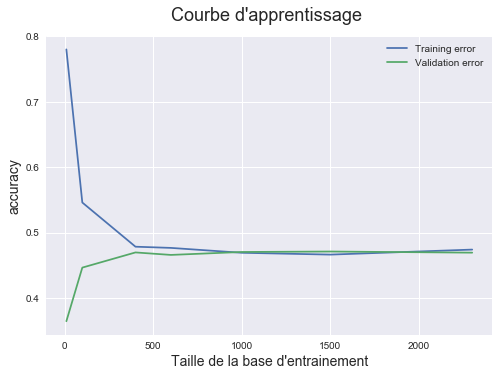

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('accuracy', fontsize=14)
plt.xlabel('Taille de la base d\'entrainement', fontsize=14)
plt.title("Courbe d'apprentissage ", fontsize=18, y=1.03)
plt.legend()

SUMMARY : 
1. Model with Random Forest has a better accuracy but a slight accuracy : 0.475
2. Model with linear SVC has no overfitting and the same scores for both training and test and a good accuracy : 0.47
3. Bookmakers (with a lot of data) reaches an accuracy of 0.55
3. Linear SVC, as in the paper, seems to be the best one
4. Prediction could be better with more data to build an accurate Xg model
